In [1]:
import glob
import h5py
import numpy as np
import os
import pylab
import scipy.linalg
import scipy as sp
import sys

from numpy import array, concatenate, zeros
from numpy.random import randn
from scipy.optimize import minimize

from functools import reduce

from openfermion.config import *
from openfermionprojectq import *

from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner, bravyi_kitaev, get_sparse_operator
from openfermion.utils import uccsd_singlet_paramsize
from openfermion.ops import FermionOperator

from openfermionpsi4 import run_psi4

from projectq.ops import X, All, Measure
from projectq.backends import CommandPrinter, CircuitDrawer
from projectq.ops import (BasicGate,
                          H,
                          X,
                          CNOT,
                          Measure,
                          Z,
                          Swap,
                          C,
                          Rx,
                          Rz)
from projectq import MainEngine
from projectq.ops import H, X, Rz, Rx, CNOT
from projectq.meta import Control
from projectq.backends._circuits import to_latex
from projectq.backends import _printer

%matplotlib inline

hartree_to_kcal = 627.50947415

In [2]:
def canonical_eigh(M, S):
    """Return the eigenvectors and eigenvalues in the original basis with potentially singular S"""
    #Solve for spectrum with canonical orthogonalization
    overlapCutoff = 1.0e-8
    [evals, evecs] = sp.linalg.eigh(S)

    #Determine rank
    RankOverlap = np.sum(evals > overlapCutoff)
    nullity = len(evals) - RankOverlap
    #Cutoff
    evals = evals[nullity:]
    evecs = evecs[:, nullity:]

    #Make transformation matrix
    U = np.dot(evecs, np.diag(evals**(-0.5)))

    #Transform the Hamiltonian and find the new eigenvectors
    M_prime = np.dot(np.conj(U).T, np.dot(M, U))
    S_prime = np.dot(np.conj(U).T, np.dot(S, U))

    e_vals, e_vecs = sp.linalg.eigh(M_prime, S_prime)
    #Transform eigenvectors back to original basis
    e_vecs = np.dot(U, e_vecs)
    
    return e_vals, e_vecs, U

def FindSymmTransform(M, S, val):
    """Find a transform to project onto the eigenspace corresponding to eigenvalue val of operator 
    representation M with overlap S"""
    e_vals, e_vecs, U = canonical_eigh(M, S)
    indices = np.where(np.abs(e_vals-val) < 0.1)[0]
    U = e_vecs[:, indices]
    return U

In [3]:
# Load files
molecule_filenames = sorted(glob.glob('data/*.hdf5'))
test_molecule = MolecularData(filename=molecule_filenames[0])
print("Number of spatial basis functions: {}".format(test_molecule.n_orbitals))
print("Number of electrons: {}".format(test_molecule.n_electrons))
test_molecule = None

Number of spatial basis functions: 52
Number of electrons: 16


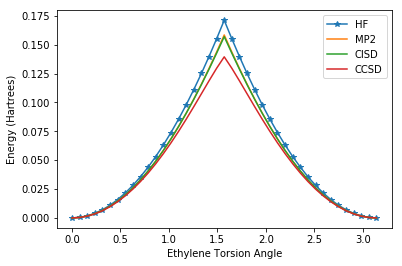

In [4]:
# Plot CCSD curve for angle
angles = []
hf_energies = []
mp2_energies = []
cisd_energies = []
ccsd_energies = []

for filename in molecule_filenames:
    angle = float(filename.split('_')[-1].rstrip('.hdf5'))
    molecule = MolecularData(filename=filename)
    
    angles.append(angle)
    hf_energies.append(molecule.hf_energy)
    mp2_energies.append(molecule.mp2_energy)
    cisd_energies.append(molecule.cisd_energy)
    ccsd_energies.append(molecule.ccsd_energy)

pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Energy (Hartrees)")
pylab.plot(angles, np.array(hf_energies) - hf_energies[0], '*-', label="HF")
pylab.plot(angles, np.array(mp2_energies) - mp2_energies[0], label="MP2")
pylab.plot(angles, np.array(cisd_energies) - cisd_energies[0], label="CISD")
pylab.plot(angles, np.array(ccsd_energies) - ccsd_energies[0], label="CCSD")
pylab.legend()

Qubit Hamiltonian Matrix
[[-76.86638025+0.j   0.00000000+0.j]
 [  0.00000000+0.j -78.04891685+0.j]]

Energy: -78.04891684583123	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.86759778+0.j   0.00000000+0.j]
 [  0.00000000+0.j -78.04847427+0.j]]

Energy: -78.04847426828763	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.87112449+0.j   0.00000000+0.j]
 [  0.00000000+0.j -78.04714686+0.j]]

Energy: -78.04714686089714	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.87662076+0.j   0.00000000+0.j]
 [  0.00000000+0.j -78.04493561+0.j]]

Energy: -78.04493561435751	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.88362529+0.j   0.00000000+0.j]
 [  0.00000000+0.j -78.04184223+0.j]]

Energy: -78.04184222696486	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.89165449+0.j   0.00000000+0.j]
 [  0.00000000+0.j -78.03786917+0.j]]

Energy: -78.03786916696703	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.90027299+0.j   


Energy: -78.0594207637029	 Number: (1.9999999999999996+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.88362529+0.j   0.00000000+0.j   0.00000000+0.j   0.00000000+0.j
    0.00000000+0.j]
 [  0.00000000+0.j -77.54477256+0.j   0.00000000+0.j   0.08547376+0.j
    0.00000000+0.j]
 [  0.00000000+0.j   0.00000000+0.j -77.72659535+0.j   0.00000000+0.j
    0.00000000+0.j]
 [  0.00000000+0.j   0.08547376+0.j   0.00000000+0.j -78.04184223+0.j
    0.00000000+0.j]
 [  0.00000000+0.j   0.00000000+0.j   0.00000000+0.j   0.00000000+0.j
  -77.42906485+0.j]]

Energy: -78.05612924707025	 Number: (1.9999999999999998+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.89165449+0.j   0.00000000+0.j   0.00000000+0.j   0.00000000+0.j
    0.00000000+0.j]
 [  0.00000000+0.j -77.56044884+0.j   0.00000000+0.j   0.08329680+0.j
    0.00000000+0.j]
 [  0.00000000+0.j   0.00000000+0.j -77.73350753+0.j   0.00000000+0.j
    0.00000000+0.j]
 [  0.00000000+0.j   0.08329680+0.j   0.00000000+0.j -78.03786917+0.j
    0.00

Energy: -77.95338441210059	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[ -7.69791969e+01+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j  -7.78222475e+01+0.j   0.00000000e+00+0.j
    6.62173968e-02+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   0.00000000e+00+0.j  -7.78062656e+01+0.j
    0.00000000e+00+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   6.62173968e-02+0.j   0.00000000e+00+0.j
   -7.79092428e+01+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j  -7.74488925e+01+0.j]]

Energy: -77.94497134845615	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[ -7.69817178e+01+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j  -7.78405100e+01+0.j   0.00000000e+00+0.j
    6.60802623e-02+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   0.00000000e+00+0.j  -7.78074510e+01+0

    0.00000000e+00+0.j  -7.74427042e+01+0.j]]

Energy: -78.01979227303362	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[ -7.69265243e+01+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j  -7.76379027e+01+0.j   0.00000000e+00+0.j
    7.48695490e-02+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   0.00000000e+00+0.j  -7.77638671e+01+0.j
    0.00000000e+00+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   7.48695490e-02+0.j   0.00000000e+00+0.j
   -7.80132609e+01+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j  -7.74404643e+01+0.j]]

Energy: -78.0276434147554	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[ -7.69179425e+01+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j  -7.76171833e+01+0.j   0.00000000e+00+0.j
    7.67774070e-02+0.j   0.00000000e+00+0.j]
 [  0.00000000e+

Qubit Hamiltonian Matrix
[[ -7.70197957e+01+0.j   6.66537792e-18+0.j  -3.58983091e-24+0.j ...,
   -5.15268601e-25+0.j   4.35860795e-03+0.j   2.39101678e-03+0.j]
 [  6.66537792e-18+0.j  -7.66873595e+01+0.j   2.46797183e-03+0.j ...,
    6.05550725e-06+0.j  -7.14131555e-15+0.j   2.91029656e-03+0.j]
 [ -3.58983091e-24+0.j   2.46797183e-03+0.j  -7.67974336e+01+0.j ...,
    4.05042739e-05+0.j   1.41950816e-19+0.j  -5.12486116e-03+0.j]
 ..., 
 [ -5.15268601e-25+0.j   6.05550725e-06+0.j   4.05042739e-05+0.j ...,
   -7.69814103e+01+0.j   5.59298635e-22+0.j   5.21451612e-04+0.j]
 [  4.35860795e-03+0.j  -7.14131555e-15+0.j   1.41950816e-19+0.j ...,
    5.59298635e-22+0.j  -7.71961426e+01+0.j   2.26277496e-15+0.j]
 [  2.39101678e-03+0.j   2.91029656e-03+0.j  -5.12486116e-03+0.j ...,
    5.21451612e-04+0.j   2.26277496e-15+0.j  -7.68963278e+01+0.j]]

Energy: -78.0601458918211	 Number: (3.9999999999999987+0j)	 Sz:(-6.298986696732369e-35+0j)	 S^2:(6.926542023291186e-34+0j)
Qubit Hamiltonian Matrix
[[

Qubit Hamiltonian Matrix
[[ -7.69513408e+01+0.j   6.67078883e-18+0.j   5.03830754e-23+0.j ...,
   -1.18834744e-24+0.j   2.32328952e-03+0.j   2.29864314e-03+0.j]
 [  6.67078883e-18+0.j  -7.67479886e+01+0.j   4.83579153e-03+0.j ...,
    1.39656220e-05+0.j  -7.14702033e-15+0.j   2.26923086e-03+0.j]
 [  5.03830754e-23+0.j   4.83579153e-03+0.j  -7.68137042e+01+0.j ...,
    3.73521977e-05+0.j   2.54219919e-19+0.j  -1.12258240e-02+0.j]
 ..., 
 [ -1.18834744e-24+0.j   1.39656220e-05+0.j   3.73521977e-05+0.j ...,
   -7.70431363e+01+0.j   1.28989249e-21+0.j   1.11558627e-03+0.j]
 [  2.32328952e-03+0.j  -7.14702033e-15+0.j   2.54219919e-19+0.j ...,
    1.28989249e-21+0.j  -7.72046216e+01+0.j   1.20628527e-15+0.j]
 [  2.29864314e-03+0.j   2.26923086e-03+0.j  -1.12258240e-02+0.j ...,
    1.11558627e-03+0.j   1.20628527e-15+0.j  -7.69066694e+01+0.j]]

Energy: -78.00572524844853	 Number: (4.000000000000001+0j)	 Sz:(-4.112676582721609e-34+0j)	 S^2:(4.484898203494595e-33+0j)
Qubit Hamiltonian Matrix
[[

Qubit Hamiltonian Matrix
[[ -7.68803324e+01+0.j   6.67596842e-18+0.j  -1.51902347e-23+0.j ...,
   -1.20959318e-24+0.j   1.68961723e-03+0.j   2.21875866e-03+0.j]
 [  6.67596842e-18+0.j  -7.68062837e+01+0.j   5.64172639e-03+0.j ...,
    1.42153048e-05+0.j  -7.15249590e-15+0.j   2.08666503e-03+0.j]
 [ -1.51902347e-23+0.j   5.64172639e-03+0.j  -7.68238900e+01+0.j ...,
    3.60143816e-05+0.j   3.27405951e-19+0.j  -1.19449821e-02+0.j]
 ..., 
 [ -1.20959318e-24+0.j   1.42153048e-05+0.j   3.60143816e-05+0.j ...,
   -7.70650967e+01+0.j   1.31295369e-21+0.j   1.16600175e-03+0.j]
 [  1.68961723e-03+0.j  -7.15249590e-15+0.j   3.27405951e-19+0.j ...,
    1.31295369e-21+0.j  -7.71934447e+01+0.j   8.77364974e-16+0.j]
 [  2.21875866e-03+0.j   2.08666503e-03+0.j  -1.19449821e-02+0.j ...,
    1.16600175e-03+0.j   8.77364974e-16+0.j  -7.69191164e+01+0.j]]

Energy: -77.94092496581273	 Number: (4.000000000000001+0j)	 Sz:(-4.1948257630201255e-34+0j)	 S^2:(4.5877136160199444e-33+0j)
Qubit Hamiltonian Matrix


Qubit Hamiltonian Matrix
[[ -7.69686516e+01+0.j   6.66927690e-18+0.j   4.28511577e-23+0.j ...,
   -1.13061156e-24+0.j   2.67362722e-03+0.j   2.32373988e-03+0.j]
 [  6.66927690e-18+0.j  -7.67309883e+01+0.j   4.69341780e-03+0.j ...,
    1.32871021e-05+0.j  -7.14542292e-15+0.j   2.37796653e-03+0.j]
 [  4.28511577e-23+0.j   4.69341780e-03+0.j  -7.68091366e+01+0.j ...,
    3.79557185e-05+0.j   2.49255228e-19+0.j  -1.07411367e-02+0.j]
 ..., 
 [ -1.13061156e-24+0.j   1.32871021e-05+0.j   3.79557185e-05+0.j ...,
   -7.70308450e+01+0.j   1.22722305e-21+0.j   1.07401357e-03+0.j]
 [  2.67362722e-03+0.j  -7.14542292e-15+0.j   2.49255228e-19+0.j ...,
    1.22722305e-21+0.j  -7.72039303e+01+0.j   1.38813742e-15+0.j]
 [  2.32373988e-03+0.j   2.37796653e-03+0.j  -1.07411367e-02+0.j ...,
    1.07401357e-03+0.j   1.38813742e-15+0.j  -7.69021075e+01+0.j]]

Energy: -78.02283693916425	 Number: (4.000000000000003+0j)	 Sz:(-3.4578911568441524e-34+0j)	 S^2:(3.86598495880059e-33+0j)
Qubit Hamiltonian Matrix
[[

Qubit Hamiltonian Matrix
[[ -7.70271846e+01+0.j   6.66498545e-18+0.j  -2.65932410e-24+0.j ...,
   -1.81682252e-25+0.j   4.66190549e-03+0.j   2.39796345e-03+0.j]
 [  6.66498545e-18+0.j  -7.66830087e+01+0.j   8.89491419e-04+0.j ...,
    2.13515474e-06+0.j  -7.14090442e-15+0.j   3.00640562e-03+0.j]
 [ -2.65932410e-24+0.j   8.89491419e-04+0.j  -7.67965637e+01+0.j ...,
    4.09274492e-05+0.j   5.17299485e-20+0.j  -1.82079460e-03+0.j]
 ..., 
 [ -1.81682252e-25+0.j   2.13515474e-06+0.j   4.09274492e-05+0.j ...,
   -7.69738237e+01+0.j   1.97207118e-22+0.j   1.85632278e-04+0.j]
 [  4.66190549e-03+0.j  -7.14090442e-15+0.j   5.17299485e-20+0.j ...,
    1.97207118e-22+0.j  -7.71948430e+01+0.j   2.42021040e-15+0.j]
 [  2.39796345e-03+0.j   3.00640562e-03+0.j  -1.82079460e-03+0.j ...,
    1.85632278e-04+0.j   2.42021040e-15+0.j  -7.68973808e+01+0.j]]

Energy: -78.06353807632235	 Number: (4.0000000000000036+0j)	 Sz:(-7.77125914788307e-36+0j)	 S^2:(9.047308991294856e-35+0j)
Qubit Hamiltonian Matrix
[[

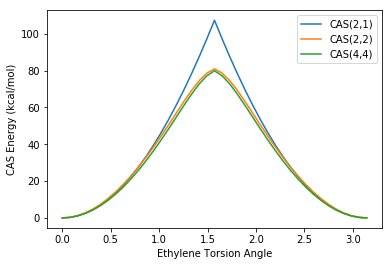

In [5]:
# Examine a CAS(n electrons, n spatial orbitals) active space - 2 x number spatial orbitals = qubits
angles = [float(filename.split('_')[-1].rstrip('.hdf5')) for filename in molecule_filenames]
cas_energies = {}
original_electrons = 16
for n_electrons, n_orbitals in [(2,1), (2,2), (4,4)]:
    occupied_indices = range(8 - n_electrons // 2)
    active_indices = range(8 - n_electrons // 2, 8 - n_electrons // 2 + n_orbitals)
    active_electrons = original_electrons - len(occupied_indices) * 2
    active_qubits = len(active_indices) * 2

    # Define a qubit number operator
    number_operator = get_sparse_operator(jordan_wigner(
        sum([FermionOperator( ((i, 1), (i, 0)), 1.0) for i in range(active_qubits)], FermionOperator()))).todense()
    spinx_operator = get_sparse_operator(jordan_wigner(
            sum([FermionOperator( ((2*i, 1), (2*i+1, 0)), 0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()) +
            sum([FermionOperator( ((2*i+1, 1), (2*i, 0)), 0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()))).todense()
    spiny_operator = get_sparse_operator(jordan_wigner(
            sum([FermionOperator( ((2*i, 1), (2*i+1, 0)), -0.5j) 
                 for i in range(active_qubits // 2)], FermionOperator()) +
            sum([FermionOperator( ((2*i+1, 1), (2*i, 0)), 0.5j) 
                 for i in range(active_qubits // 2)], FermionOperator()))).todense()
    spinz_operator = get_sparse_operator(jordan_wigner(
            sum([FermionOperator( ((2*i, 1), (2*i, 0)), 0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()) +
            sum([FermionOperator( ((2*i+1, 1), (2*i+1, 0)), -0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()))).todense()
    spin2_operator = (np.dot(spinx_operator, spinx_operator) +
                      np.dot(spiny_operator, spiny_operator) +
                      np.dot(spinz_operator, spinz_operator))
    cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)] = []
    for filename in molecule_filenames:
        molecule = MolecularData(filename=filename)
        # Extract active space integrals
        hamiltonian = (molecule.
                       get_molecular_hamiltonian(
                           occupied_indices=occupied_indices,
                           active_indices=active_indices))
        fermion_hamiltonian = get_fermion_operator(hamiltonian)

        # Build qubit Hamiltonian
        qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

        # Build matrix representation & diagonalize
        qubit_hamiltonian_matrix = get_sparse_operator(hamiltonian).todense()

        # Project to S^2 = 0 subspace
        U_s2 = FindSymmTransform(spin2_operator, 
                                 np.eye(spin2_operator.shape[0]),
                                 0.0)
        qubit_hamiltonian_matrix = np.dot(np.conj(U_s2).T, np.dot(qubit_hamiltonian_matrix, U_s2))
        
        print('Qubit Hamiltonian Matrix')
        print(qubit_hamiltonian_matrix)
        print()
        
        eigvals, eigvecs = scipy.linalg.eigh(qubit_hamiltonian_matrix)
        ground_state = eigvecs[:,0][:, np.newaxis]
        energy = eigvals[0]
        number = reduce(np.dot,
                        (np.conj(ground_state.T), np.conj(U_s2).T, number_operator, U_s2, ground_state))[0,0]
        spinz =  reduce(np.dot,
                        (np.conj(ground_state.T), np.conj(U_s2).T, spinz_operator, U_s2, ground_state))[0,0]
        spin2 =  reduce(np.dot,
                       (np.conj(ground_state.T), np.conj(U_s2).T, spin2_operator, U_s2, ground_state))[0,0]
        
        cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)].append(energy)
        print('Energy: {}\t Number: {}\t Sz:{}\t S^2:{}'.format(energy, number, spinz, spin2))
        
    
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("CAS Energy (kcal/mol)")
for key in cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(cas_energies[key]) - cas_energies[key][0]),
               label=key)
pylab.legend()

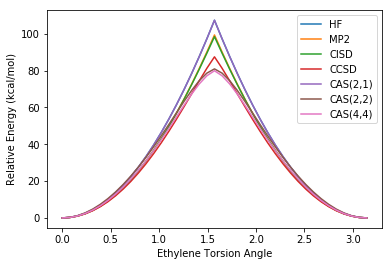

In [6]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Relative Energy (kcal/mol)")
pylab.plot(angles, hartree_to_kcal * (np.array(hf_energies) - hf_energies[0]), label="HF")
pylab.plot(angles, hartree_to_kcal * (np.array(mp2_energies) - mp2_energies[0]), label="MP2")
pylab.plot(angles, hartree_to_kcal * (np.array(cisd_energies) - cisd_energies[0]), label="CISD")
pylab.plot(angles, hartree_to_kcal * (np.array(ccsd_energies) - ccsd_energies[0]), label="CCSD")
for key in cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(cas_energies[key]) - cas_energies[key][0]),
               label=key)
pylab.legend()

In [7]:
# Make a custom ansatz for CAS(4,4) at a particular geometry
from projectq import MainEngine
from projectq.ops import H, X, Rz, Rx, CNOT
from projectq.meta import Control

mini_energies = {}
mini_amplitudes = {}
original_electrons = 16
for n_electrons, n_orbitals in [(4,4)]:#, (2,2)]:
    occupied_indices = range(8 - n_electrons // 2)
    active_indices = range(8 - n_electrons // 2, 8 - n_electrons // 2 + n_orbitals)
    active_electrons = original_electrons - len(occupied_indices) * 2
    active_qubits = len(active_indices) * 2

    # Define a qubit number operator
    number_operator = jordan_wigner(
        sum([FermionOperator( ((i, 1), (i, 0)), 1.0) for i in range(active_qubits)], FermionOperator()))
    number_operator.compress()
    spinz_operator = jordan_wigner(sum([FermionOperator( ((2*i, 1), (2*i, 0)), 0.5) 
                                        for i in range(active_qubits // 2)], FermionOperator()) +
                                   sum([FermionOperator( ((2*i+1, 1), (2*i+1, 0)), -0.5) 
                                        for i in range(active_qubits // 2)], FermionOperator()))
    spinz_operator.compress()

    n_amplitudes = 2
    #current_amplitudes = 0.001 * randn(n_amplitudes)
    current_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
    mini_energies['CAS({},{})-{},{}'.format(n_electrons, n_orbitals, 3, 7)] = []
    mini_amplitudes['CAS({},{})-{},{}'.format(n_electrons, n_orbitals, 3, 7)] = []

    for file_index, filename in enumerate(molecule_filenames):
        print("Running CAS({},{}) on {}".format(n_electrons, n_orbitals, filename))
        molecule = MolecularData(filename=filename)
        # Extract active space integrals
        hamiltonian = (molecule.
                        get_molecular_hamiltonian(
                            occupied_indices=occupied_indices,
                            active_indices=active_indices))
        #print(hamiltonian)
        fermion_hamiltonian = get_fermion_operator(hamiltonian)


        # Use a Jordan-Wigner encoding, and compress to remove 0 imaginary components
        #qubit_hamiltonian = bravyi_kitaev(fermion_hamiltonian)
        #qubit_hamiltonian.compress()
        #print('Bravyi-Kitaev')
        #print(qubit_hamiltonian)
        qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
        qubit_hamiltonian.compress()
        print('Jordan-Wigner')
        print(qubit_hamiltonian)
        # Set standard UCCSD Compiler engine
        compiler_engine = MainEngine()

        def energy_objective(packed_amplitudes):
            """Evaluate the energy of a mini singlet wavefunction with packed_amplitudes
            Args:
                packed_amplitudes(ndarray): Compact array that stores the unique
                    amplitudes

            Returns:
                energy(float): Energy corresponding to the given amplitudes
            """
            # Set Jordan-Wigner initial state with correct number of electrons
            # Qubits 0, 1, 2 and 3 are set to occupied by electron
            # Qubits 4, 5, 6 and 7 are zero
            # Alternatively we could set 0, 1 and 4, 5 to occupied
            wavefunction = compiler_engine.allocate_qureg(active_qubits)
            for i in range(4):
                X | wavefunction[i]

            # Build the circuit and act it on the wavefunction

            # Set one of qubits, using occupied qubits 0 and 1 and unoccupied 4 and 5
            H | wavefunction[0]
            H | wavefunction[1]
            H | wavefunction[4]
            Rx(-np.pi/2) | wavefunction[5]
            CNOT | (wavefunction[0], wavefunction[1])
            CNOT | (wavefunction[1], wavefunction[4])
            CNOT | (wavefunction[4], wavefunction[5])
            
            Rz(packed_amplitudes[0]) | wavefunction[3]
            
            CNOT | (wavefunction[4], wavefunction[5])            
            CNOT | (wavefunction[1], wavefunction[4])
            CNOT | (wavefunction[0], wavefunction[1])           
            Rx(np.pi/2) | wavefunction[5]
            H | wavefunction[4]
            H | wavefunction[1]
            H | wavefunction[0]
            
            # Set two of qubits, using occupied qubits 2 and 3 and unoccupied 6 and 7
            H | wavefunction[2]
            H | wavefunction[3]
            H | wavefunction[6]
            Rx(-np.pi/2) | wavefunction[7]
            CNOT | (wavefunction[2], wavefunction[3])
            CNOT | (wavefunction[3], wavefunction[6])
            CNOT | (wavefunction[6], wavefunction[7])            

            Rz(packed_amplitudes[1]) | wavefunction[7]
            
            CNOT | (wavefunction[6], wavefunction[7]) 
            CNOT | (wavefunction[3], wavefunction[6])
            CNOT | (wavefunction[2], wavefunction[3])
            Rx(np.pi/2) | wavefunction[7]
            H | wavefunction[6]
            H | wavefunction[3]
            H | wavefunction[2]               
            
            compiler_engine.flush()

            # Evaluate the energy and reset wavefunction
            energy = compiler_engine.backend.get_expectation_value(qubit_hamiltonian, wavefunction)
            number = compiler_engine.backend.get_expectation_value(number_operator, wavefunction)
            spinz = compiler_engine.backend.get_expectation_value(spinz_operator, wavefunction)
            print("Energy: {}\t Number:{}\t Sz:{}".format(energy, number, spinz))
            All(Measure) | wavefunction
            compiler_engine.flush()
            return energy

        initial_energy = energy_objective(current_amplitudes)

        # Run VQE Optimization to find new CCSD parameters
        opt_result = minimize(energy_objective, current_amplitudes,
                              method="l-bfgs-b", options={'disp':True})

        opt_energy, opt_amplitudes = opt_result.fun, opt_result.x

        # Use previous interation as guess for next iteration
        current_amplitudes = opt_amplitudes[:]

        # Store energy and amplitudes
        mini_energies['CAS({},{})-{},{}'.format(n_electrons, n_orbitals, 3, 7)].append(opt_energy)
        mini_amplitudes['CAS({},{})-{},{}'.format(n_electrons, n_orbitals, 3, 7)].append([opt_amplitudes])

        print("\nInitial Energy: {}".format(initial_energy))
        print("Optimal mini Singlet Energy: {}".format(opt_energy))
        print("Optimal mini Singlet Amplitudes: {}".format(opt_amplitudes))
        print("Exact FCI Energy: {} Hartrees".format(
               cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)][file_index]))

Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_0.00000.hdf5
Jordan-Wigner
-76.9548696163446 I +
0.24321144558961558 Z0 +
0.24321144558961547 Z1 +
0.1904525456945721 Z2 +
0.1904525456945721 Z3 +
0.042865390690525605 Z4 +
0.042865390690525605 Z5 +
-0.06320369686950596 Z6 +
-0.06320369686950596 Z7 +
0.08572034948181355 Z0 Z2 +
0.07681177448389447 Z0 Z4 +
0.05967480476991765 Z0 Z6 +
0.09596076711525654 Z0 Z1 +
0.001965421277190601 Y0 X1 X2 Y3 +
-0.001965421277190601 Y0 Y1 X2 X3 +
-0.001965421277190601 X0 X1 Y2 Y3 +
0.001965421277190601 X0 Y1 Y2 X3 +
0.0025919329002382662 Y0 X1 X4 Y5 +
-0.0025919329002382662 Y0 Y1 X4 X5 +
-0.0025919329002382662 X0 X1 Y4 Y5 +
0.0025919329002382662 X0 Y1 Y4 X5 +
0.002318442273017267 Y0 X1 X6 Y7 +
-0.002318442273017267 Y0 Y1 X6 X7 +
-0.002318442273017267 X0 X1 Y6 Y7 +
0.002318442273017267 X0 Y1 Y6 X7 +
0.08768577075900415 Z0 Z3 +
0.07940370738413274 Z0 Z5 +
0.06199324704293492 Z0 Z7 +
0.08572034948181355 Z1 Z3 +
0.07681177448389447 Z1 Z5 +
0.0596748047699

Energy: -78.04719836729429	 Number:3.9999999999999947	 Sz:0.0
Energy: -78.04719836729515	 Number:3.9999999999999964	 Sz:0.0
Energy: -77.82396071528676	 Number:3.999999999999996	 Sz:0.0
Energy: -77.82396071528673	 Number:3.999999999999995	 Sz:0.0
Energy: -77.82396071119969	 Number:3.999999999999996	 Sz:0.0
Energy: -78.04719837348998	 Number:3.9999999999999947	 Sz:0.0
Energy: -78.04719837348996	 Number:3.9999999999999947	 Sz:0.0
Energy: -78.04719837349002	 Number:3.9999999999999942	 Sz:0.0

Initial Energy: -78.04719836729429
Optimal mini Singlet Energy: -78.04719837348998
Optimal mini Singlet Amplitudes: [ 0.00053494  0.01456958]
Exact FCI Energy: -78.06226379621577 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_0.23562.hdf5
Jordan-Wigner
-76.95626008031641 I +
0.24519328183834524 Z0 +
-0.002645022194277528 Y0 Z1 Y2 +
-0.002645022194277528 X0 Z1 X2 +
0.24519328183834518 Z1 +
-0.002645022194277527 Y1 Z2 Y3 +
-0.002645022194277527 X1 Z2 X3 +
0.18729016495263043 Z2 +
0.1872901

Energy: -78.0418971983138	 Number:3.9999999999999964	 Sz:0.0
Energy: -78.04189719831548	 Number:3.999999999999994	 Sz:0.0
Energy: -77.8229597039797	 Number:3.9999999999999947	 Sz:0.0
Energy: -77.8229597039797	 Number:3.9999999999999947	 Sz:0.0
Energy: -77.82295969997008	 Number:3.9999999999999956	 Sz:0.0
Energy: -78.0418972305331	 Number:3.999999999999994	 Sz:0.0
Energy: -78.04189723053312	 Number:3.999999999999995	 Sz:0.0
Energy: -78.04189723053337	 Number:3.9999999999999947	 Sz:0.0

Initial Energy: -78.04189719831376
Optimal mini Singlet Energy: -78.0418972305331
Optimal mini Singlet Amplitudes: [ 0.00053491  0.0151465 ]
Exact FCI Energy: -78.05719296526432 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_0.39270.hdf5
Jordan-Wigner
-76.95837751002902 I +
0.24828323479646647 Z0 +
-0.003970758540392262 Y0 Z1 Y2 +
-0.003970758540392262 X0 Z1 X2 +
0.24828323479646644 Z1 +
-0.003970758540392262 Y1 Z2 Y3 +
-0.003970758540392262 X1 Z2 X3 +
0.18218389960760067 Z2 +
0.182183899607

Energy: -78.03307991084367	 Number:3.9999999999999956	 Sz:0.0
Energy: -77.82021189263259	 Number:3.999999999999996	 Sz:0.0
Energy: -77.82021189263251	 Number:3.9999999999999947	 Sz:0.0
Energy: -77.82021188873327	 Number:3.9999999999999947	 Sz:0.0
Energy: -78.03307997338102	 Number:3.999999999999997	 Sz:0.0
Energy: -78.03307997338102	 Number:3.9999999999999973	 Sz:0.0
Energy: -78.03307997338106	 Number:3.9999999999999933	 Sz:0.0

Initial Energy: -78.0330799108413
Optimal mini Singlet Energy: -78.03307997338102
Optimal mini Singlet Amplitudes: [ 0.00053781  0.01608079]
Exact FCI Energy: -78.04883194959983 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_0.54978.hdf5
Jordan-Wigner
-76.96083326599802 I +
0.25218325086669346 Z0 +
-0.004882772262077524 Y0 Z1 Y2 +
-0.004882772262077524 X0 Z1 X2 +
0.2521832508666934 Z1 +
-0.004882772262077521 Y1 Z2 Y3 +
-0.004882772262077521 X1 Z2 X3 +
0.17542510428153893 Z2 +
0.17542510428153893 Z3 +
0.05372748752927571 Z4 +
0.053727487529275766 Z

Energy: -77.81499074896472	 Number:3.999999999999996	 Sz:0.0
Energy: -77.8149907451947	 Number:3.9999999999999956	 Sz:0.0
Energy: -78.02077658130696	 Number:3.9999999999999956	 Sz:0.0
Energy: -78.02077658130695	 Number:3.9999999999999947	 Sz:0.0
Energy: -78.02077658130716	 Number:3.999999999999996	 Sz:0.0

Initial Energy: -78.02077649260882
Optimal mini Singlet Energy: -78.02077658130696
Optimal mini Singlet Amplitudes: [ 0.00052901  0.01722717]
Exact FCI Energy: -78.03731313695508 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_0.70686.hdf5
Jordan-Wigner
-76.9630269648662 I +
0.2564764896489901 Z0 +
-0.005458585712380202 Y0 Z1 Y2 +
-0.005458585712380202 X0 Z1 X2 +
0.25647648964899017 Z1 +
-0.005458585712380203 Y1 Z2 Y3 +
-0.005458585712380203 X1 Z2 X3 +
0.1675656682890903 Z2 +
0.1675656682890902 Z3 +
0.05991042675143479 Z4 +
0.05991042675143481 Z5 +
-0.06343193663133927 Z6 +
-0.06343193663133936 Z7 +
0.08569968687246331 Z0 Z2 +
0.07652370916145516 Z0 Z4 +
0.05973486834170

Energy: -78.00503345905388	 Number:3.9999999999999956	 Sz:0.0
Energy: -77.8069399554016	 Number:3.999999999999996	 Sz:0.0
Energy: -77.80693995540152	 Number:3.999999999999992	 Sz:0.0
Energy: -77.80693995177202	 Number:3.9999999999999947	 Sz:0.0
Energy: -78.00503356476133	 Number:3.9999999999999947	 Sz:0.0
Energy: -78.00503356476132	 Number:3.9999999999999947	 Sz:0.0
Energy: -78.00503356476159	 Number:3.999999999999994	 Sz:0.0

Initial Energy: -78.00503345905085
Optimal mini Singlet Energy: -78.00503356476133
Optimal mini Singlet Amplitudes: [ 0.00052883  0.01853165]
Exact FCI Energy: -78.02283693916397 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_0.86394.hdf5
Jordan-Wigner
-76.96442195160961 I +
0.2608987347591446 Z0 +
-0.005793195028581311 Y0 Z1 Y2 +
-0.005793195028581311 X0 Z1 X2 +
0.26089873475914455 Z1 +
-0.005793195028581311 Y1 Z2 Y3 +
-0.005793195028581311 X1 Z2 X3 +
0.15898898429766684 Z2 +
0.15898898429766675 Z3 +
0.06691851087245186 Z4 +
0.0669185108724518 Z5 +

Energy: -77.79587242994216	 Number:3.999999999999993	 Sz:0.0
Energy: -77.79587242994221	 Number:3.9999999999999942	 Sz:0.0
Energy: -77.7958724264597	 Number:3.9999999999999947	 Sz:0.0
Energy: -77.98591699024219	 Number:3.9999999999999964	 Sz:0.0
Energy: -77.98591699024215	 Number:3.9999999999999942	 Sz:0.0
Energy: -77.9859169902424	 Number:3.9999999999999947	 Sz:0.0

Initial Energy: -77.98591684219673
Optimal mini Singlet Energy: -77.98591699024219
Optimal mini Singlet Amplitudes: [ 0.00052277  0.02001439]
Exact FCI Energy: -78.00572524844853 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_1.02102.hdf5
Jordan-Wigner
-76.96459070645967 I +
0.26529636748960117 Z0 +
-0.005961688711131131 Y0 Z1 Y2 +
-0.005961688711131131 X0 Z1 X2 +
0.26529636748960145 Z1 +
-0.005961688711131131 Y1 Z2 Y3 +
-0.005961688711131131 X1 Z2 X3 +
0.14994562693581492 Z2 +
0.14994562693581484 Z3 +
0.07451842771240882 Z4 +
0.07451842771240884 Z5 +
-0.06351355904911368 Z6 +
-0.0635135590491137 Z7 +
0.08566

Energy: -77.78173548658836	 Number:3.9999999999999956	 Sz:0.0
Energy: -77.96351602366765	 Number:3.999999999999997	 Sz:0.0
Energy: -77.96351602366761	 Number:3.9999999999999942	 Sz:0.0
Energy: -77.96351602366788	 Number:3.9999999999999964	 Sz:0.0
Energy: -77.9635160244604	 Number:3.9999999999999947	 Sz:0.0
Energy: -77.96351602446038	 Number:3.9999999999999933	 Sz:0.0
Energy: -77.96351602446053	 Number:3.999999999999995	 Sz:0.0

Initial Energy: -77.96351584896243
Optimal mini Singlet Energy: -77.9635160244604
Optimal mini Singlet Amplitudes: [ 0.00050797  0.02176144]
Exact FCI Energy: -77.98655059042237 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_1.17810.hdf5
Jordan-Wigner
-76.96321487066501 I +
0.2695823516347639 Z0 +
-0.006015159611013185 Y0 Z1 Y2 +
-0.006015159611013185 X0 Z1 X2 +
0.26958235163476396 Z1 +
-0.006015159611013187 Y1 Z2 Y3 +
-0.006015159611013187 X1 Z2 X3 +
0.14060338268784445 Z2 +
0.14060338268784434 Z3 +
0.08253034302817 Z4 +
0.08253034302817 Z5 +
-0.0

Optimal mini Singlet Energy: -77.93794752715192
Optimal mini Singlet Amplitudes: [ 0.00051481  0.02368212]
Exact FCI Energy: -77.96645703603606 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_1.33518.hdf5
Jordan-Wigner
-76.96006656115676 I +
0.27370948901301434 Z0 +
-0.00598685117933956 Y0 Z1 Y2 +
-0.00598685117933956 X0 Z1 X2 +
0.27370948901301434 Z1 +
-0.005986851179339556 Y1 Z2 Y3 +
-0.005986851179339556 X1 Z2 X3 +
0.1310854323930513 Z2 +
0.1310854323930513 Z3 +
0.09082023068724616 Z4 +
0.09082023068724616 Z5 +
-0.06346932362529033 Z6 +
-0.06346932362529033 Z7 +
0.08561324795822259 Z0 Z2 +
0.0780006208982911 Z0 Z4 +
0.06001687713723276 Z0 Z6 +
-0.002239484642728058 Z0 Y1 Z2 Y3 +
-0.002239484642728058 Z0 X1 Z2 X3 +
0.0979334915740921 Z0 Z1 +
-0.002239484642728058 Y0 Y2 +
-0.002239484642728058 X0 X2 +
0.0059279001623745355 Y0 X1 X2 Y3 +
-0.0059279001623745355 Y0 Y1 X2 X3 +
-0.0059279001623745355 X0 X1 Y2 Y3 +
0.0059279001623745355 X0 Y1 Y2 X3 +
0.008579867725367406 Y0 X1 

Energy: -77.90936248284142	 Number:3.999999999999995	 Sz:0.0
Energy: -77.90936248284143	 Number:3.9999999999999947	 Sz:0.0
Energy: -77.90936248284142	 Number:3.9999999999999956	 Sz:0.0

Initial Energy: -77.90936227432637
Optimal mini Singlet Energy: -77.90936248284142
Optimal mini Singlet Amplitudes: [ 0.00055655  0.02582022]
Exact FCI Energy: -77.94798518206515 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_1.49226.hdf5
Jordan-Wigner
-76.95499033879278 I +
0.27765632412405417 Z0 +
-0.0058987847868016505 Y0 Z1 Y2 +
-0.0058987847868016505 X0 Z1 X2 +
0.27765632412405417 Z1 +
-0.005898784786801652 Y1 Z2 Y3 +
-0.005898784786801652 X1 Z2 X3 +
0.12149483618657206 Z2 +
0.12149483618657211 Z3 +
0.0992913334003005 Z4 +
0.09929133340030047 Z5 +
-0.0634146655011489 Z6 +
-0.0634146655011489 Z7 +
0.08557470198602876 Z0 Z2 +
0.07856961161819669 Z0 Z4 +
0.060116181357641935 Z0 Z6 +
-0.0025119626001188105 Z0 Y1 Z2 Y3 +
-0.0025119626001188105 Z0 X1 Z2 X3 +
0.09842074307917072 Z0 Z1 +
-0.0

Energy: -77.87795534499715	 Number:3.9999999999999925	 Sz:0.0
Energy: -77.87795534499745	 Number:3.9999999999999942	 Sz:0.0
Energy: -77.87795534609167	 Number:3.999999999999996	 Sz:0.0
Energy: -77.87795534609167	 Number:3.999999999999996	 Sz:0.0
Energy: -77.87795534609172	 Number:3.999999999999993	 Sz:0.0

Initial Energy: -77.87795511663082
Optimal mini Singlet Energy: -77.87795534609167
Optimal mini Singlet Amplitudes: [ 0.00052913  0.02811844]
Exact FCI Energy: -77.93658157664288 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_1.64934.hdf5
Jordan-Wigner
-76.95499033879287 I +
0.2776563241240507 Z0 +
-0.005898784786803574 Y0 Z1 Y2 +
-0.005898784786803574 X0 Z1 X2 +
0.2776563241240507 Z1 +
-0.005898784786803576 Y1 Z2 Y3 +
-0.005898784786803576 X1 Z2 X3 +
0.12149483618656515 Z2 +
0.12149483618656526 Z3 +
0.09929133340030274 Z4 +
0.09929133340030272 Z5 +
-0.06341466550115465 Z6 +
-0.06341466550115464 Z7 +
0.08557470198602922 Z0 Z2 +
0.07856961161819769 Z0 Z4 +
0.060116181357

Energy: -77.90936225788823	 Number:3.999999999999994	 Sz:0.0
Energy: -77.74445532064755	 Number:3.9999999999999964	 Sz:0.0
Energy: -77.7444553206475	 Number:3.9999999999999947	 Sz:0.0
Energy: -77.74445532367031	 Number:3.999999999999997	 Sz:0.0
Energy: -77.9093624812188	 Number:3.9999999999999933	 Sz:0.0
Energy: -77.90936248121882	 Number:3.9999999999999933	 Sz:0.0
Energy: -77.90936248121842	 Number:3.9999999999999942	 Sz:0.0
Energy: -77.90936248285647	 Number:3.9999999999999964	 Sz:0.0
Energy: -77.90936248285645	 Number:3.9999999999999956	 Sz:0.0
Energy: -77.90936248285645	 Number:3.9999999999999916	 Sz:0.0

Initial Energy: -77.90936225789217
Optimal mini Singlet Energy: -77.90936248285647
Optimal mini Singlet Amplitudes: [ 0.00051708  0.02579025]
Exact FCI Energy: -77.94798518206495 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_1.80642.hdf5
Jordan-Wigner
-76.96006656115686 I +
0.2737094890130368 Z0 +
-0.005986851179340981 Y0 Z1 Y2 +
-0.005986851179340981 X0 Z1 X2 +
0.2

Energy: -77.93794752714619	 Number:3.9999999999999942	 Sz:0.0

Initial Energy: -77.9379473242371
Optimal mini Singlet Energy: -77.93794752714616
Optimal mini Singlet Amplitudes: [ 0.00049569  0.02368392]
Exact FCI Energy: -77.96645703603613 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_1.96350.hdf5
Jordan-Wigner
-76.96321487066481 I +
0.26958235163475774 Z0 +
-0.006015159611015053 Y0 Z1 Y2 +
-0.006015159611015053 X0 Z1 X2 +
0.26958235163475774 Z1 +
-0.006015159611015048 Y1 Z2 Y3 +
-0.006015159611015048 X1 Z2 X3 +
0.14060338268784084 Z2 +
0.14060338268784095 Z3 +
0.08253034302817769 Z4 +
0.08253034302817762 Z5 +
-0.06350708581399905 Z6 +
-0.06350708581399907 Z7 +
0.08564422773533172 Z0 Z2 +
0.07749549272335894 Z0 Z4 +
0.05992434101436061 Z0 Z6 +
-0.0019033197224282165 Z0 Y1 Z2 Y3 +
-0.0019033197224282165 Z0 X1 Z2 X3 +
0.09744709248902676 Z0 Z1 +
-0.0019033197224282165 Y0 Y2 +
-0.0019033197224282165 X0 X2 +
0.005903250048402264 Y0 X1 X2 Y3 +
-0.005903250048402264 Y0 Y1 X2 

Energy: -77.9635160231446	 Number:3.9999999999999956	 Sz:0.0
Energy: -77.96351602314425	 Number:3.9999999999999947	 Sz:0.0
Energy: -77.96351602444663	 Number:3.9999999999999956	 Sz:0.0
Energy: -77.96351602444665	 Number:3.9999999999999956	 Sz:0.0
Energy: -77.96351602444668	 Number:3.9999999999999956	 Sz:0.0

Initial Energy: -77.9635158496767
Optimal mini Singlet Energy: -77.96351602444663
Optimal mini Singlet Amplitudes: [ 0.00048601  0.02175744]
Exact FCI Energy: -77.98655059042227 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_2.12058.hdf5
Jordan-Wigner
-76.96459070645992 I +
0.26529636748955665 Z0 +
-0.005961688711128215 Y0 Z1 Y2 +
-0.005961688711128215 X0 Z1 X2 +
0.26529636748955665 Z1 +
-0.00596168871112821 Y1 Z2 Y3 +
-0.00596168871112821 X1 Z2 X3 +
0.14994562693575453 Z2 +
0.14994562693575458 Z3 +
0.07451842771237076 Z4 +
0.0745184277123708 Z5 +
-0.06351355904906042 Z6 +
-0.06351355904906039 Z7 +
0.08566831746396364 Z0 Z2 +
0.07706740370508122 Z0 Z4 +
0.059845040185

Energy: -77.79586400613344	 Number:3.999999999999995	 Sz:0.0
Energy: -77.98591699057141	 Number:3.9999999999999947	 Sz:0.0
Energy: -77.98591699057145	 Number:3.9999999999999964	 Sz:0.0
Energy: -77.98591699057124	 Number:3.9999999999999964	 Sz:0.0

Initial Energy: -77.98591682672297
Optimal mini Singlet Energy: -77.98591699057141
Optimal mini Singlet Amplitudes: [ 0.00047941  0.02012515]
Exact FCI Energy: -78.00572524844839 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_2.27765.hdf5
Jordan-Wigner
-76.96442195160976 I +
0.26089873475915437 Z0 +
-0.005793195028580301 Y0 Z1 Y2 +
-0.005793195028580301 X0 Z1 X2 +
0.26089873475915437 Z1 +
-0.0057931950285803 Y1 Z2 Y3 +
-0.0057931950285803 X1 Z2 X3 +
0.1589889842976762 Z2 +
0.15898898429767627 Z3 +
0.06691851087245271 Z4 +
0.06691851087245262 Z5 +
-0.06348621583815509 Z6 +
-0.06348621583815509 Z7 +
0.08568646705923705 Z0 Z2 +
0.07673571689777625 Z0 Z4 +
0.05978179061825097 Z0 Z6 +
-0.0010563381731495912 Z0 Y1 Z2 Y3 +
-0.001056338

Energy: -78.0050335647739	 Number:3.9999999999999964	 Sz:0.0
Energy: -78.0050335647737	 Number:3.9999999999999964	 Sz:0.0

Initial Energy: -78.00503343761717
Optimal mini Singlet Energy: -78.00503356477383
Optimal mini Singlet Amplitudes: [ 0.00049457  0.0186293 ]
Exact FCI Energy: -78.02283693916425 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_2.43473.hdf5
Jordan-Wigner
-76.96302696486634 I +
0.2564764896489643 Z0 +
-0.005458585712379421 Y0 Z1 Y2 +
-0.005458585712379421 X0 Z1 X2 +
0.2564764896489643 Z1 +
-0.005458585712379422 Y1 Z2 Y3 +
-0.005458585712379422 X1 Z2 X3 +
0.16756566828906885 Z2 +
0.16756566828906896 Z3 +
0.05991042675141209 Z4 +
0.05991042675141209 Z5 +
-0.06343193663131974 Z6 +
-0.06343193663131974 Z7 +
0.0856996868724642 Z0 Z2 +
0.07652370916145464 Z0 Z4 +
0.05973486834170979 Z0 Z6 +
-0.0005763471586732755 Z0 Y1 Z2 Y3 +
-0.0005763471586732755 Z0 X1 Z2 X3 +
0.09618273779835027 Z0 Z1 +
-0.0005763471586732755 Y0 Y2 +
-0.0005763471586732755 X0 X2 +
0.005016

Energy: -78.02077647888181	 Number:3.999999999999996	 Sz:0.0
Energy: -77.81499429338639	 Number:3.999999999999994	 Sz:0.0
Energy: -77.81499429338642	 Number:3.9999999999999947	 Sz:0.0
Energy: -77.81499429715625	 Number:3.9999999999999947	 Sz:0.0
Energy: -78.02077658066787	 Number:3.999999999999994	 Sz:0.0
Energy: -78.02077658066787	 Number:3.999999999999994	 Sz:0.0
Energy: -78.02077658066756	 Number:3.999999999999994	 Sz:0.0

Initial Energy: -78.02077647888483
Optimal mini Singlet Energy: -78.02077658066787
Optimal mini Singlet Amplitudes: [ 0.00049451  0.01732493]
Exact FCI Energy: -78.03731313695504 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_2.59181.hdf5
Jordan-Wigner
-76.9608332659982 I +
0.2521832508667014 Z0 +
-0.004882772262077701 Y0 Z1 Y2 +
-0.004882772262077701 X0 Z1 X2 +
0.2521832508667014 Z1 +
-0.004882772262077701 Y1 Z2 Y3 +
-0.004882772262077701 X1 Z2 X3 +
0.17542510428154132 Z2 +
0.17542510428154126 Z3 +
0.053727487529281415 Z4 +
0.0537274875292814 Z5 +
-

Energy: -78.03307989361595	 Number:3.999999999999995	 Sz:0.0
Energy: -78.03307989361322	 Number:3.999999999999994	 Sz:0.0
Energy: -77.8202598351065	 Number:3.999999999999996	 Sz:0.0
Energy: -77.82025983510648	 Number:3.999999999999995	 Sz:0.0
Energy: -77.82025983900546	 Number:3.999999999999994	 Sz:0.0
Energy: -78.03307997317916	 Number:3.9999999999999947	 Sz:0.0
Energy: -78.03307997317917	 Number:3.9999999999999956	 Sz:0.0
Energy: -78.03307997317887	 Number:3.999999999999994	 Sz:0.0

Initial Energy: -78.03307989361592
Optimal mini Singlet Energy: -78.03307997317916
Optimal mini Singlet Amplitudes: [ 0.00050307  0.01616859]
Exact FCI Energy: -78.04883194959983 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_2.74889.hdf5
Jordan-Wigner
-76.95837751002897 I +
0.24828323479645464 Z0 +
-0.003970758540391638 Y0 Z1 Y2 +
-0.003970758540391638 X0 Z1 X2 +
0.2482832347964547 Z1 +
-0.00397075854039164 Y1 Z2 Y3 +
-0.00397075854039164 X1 Z2 X3 +
0.18218389960758674 Z2 +
0.18218389960758

Energy: -77.82301534381035	 Number:3.9999999999999947	 Sz:0.0
Energy: -77.82301534781955	 Number:3.9999999999999964	 Sz:0.0
Energy: -78.04189723083388	 Number:3.999999999999996	 Sz:0.0
Energy: -78.04189723083388	 Number:3.999999999999996	 Sz:0.0
Energy: -78.04189723083381	 Number:3.999999999999997	 Sz:0.0

Initial Energy: -78.04189717956815
Optimal mini Singlet Energy: -78.04189723083388
Optimal mini Singlet Amplitudes: [ 0.00049752  0.01522183]
Exact FCI Energy: -78.05719296526397 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_2.90597.hdf5
Jordan-Wigner
-76.95626008031704 I +
0.24519328183831648 Z0 +
-0.002645022194277247 Y0 Z1 Y2 +
-0.002645022194277247 X0 Z1 X2 +
0.2451932818383164 Z1 +
-0.002645022194277247 Y1 Z2 Y3 +
-0.002645022194277247 X1 Z2 X3 +
0.18729016495261785 Z2 +
0.18729016495261797 Z3 +
0.045019130045127344 Z4 +
0.04501913004512732 Z5 +
-0.06323846973270889 Z6 +
-0.06323846973270887 Z7 +
0.08571853554319024 Z0 Z2 +
0.07666517220975742 Z0 Z4 +
0.0596770371

Optimal mini Singlet Energy: -78.04719837347174
Optimal mini Singlet Amplitudes: [ 0.00049478  0.0145741 ]
Exact FCI Energy: -78.06226379621602 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_3.06305.hdf5
Jordan-Wigner
-76.95503184888094 I +
0.24344217437715648 Z0 +
-0.0009360765593956772 Y0 Z1 Y2 +
-0.0009360765593956772 X0 Z1 X2 +
0.24344217437715654 Z1 +
-0.0009360765593956771 Y1 Z2 Y3 +
-0.0009360765593956771 X1 Z2 X3 +
0.1900888356877357 Z2 +
0.19008883568773582 Z3 +
0.04310887618486711 Z4 +
0.04310887618486711 Z5 +
-0.06320769304562276 Z6 +
-0.06320769304562285 Z7 +
0.08572015549992776 Z0 Z2 +
0.07679259639187615 Z0 Z4 +
0.05967495172297666 Z0 Z6 +
0.0001602306088585026 Z0 Y1 Z2 Y3 +
0.0001602306088585026 Z0 X1 Z2 X3 +
0.09594654089594441 Z0 Z1 +
0.0001602306088585026 Y0 Y2 +
0.0001602306088585026 X0 X2 +
0.002049026995879442 Y0 X1 X2 Y3 +
-0.002049026995879442 Y0 Y1 X2 X3 +
-0.002049026995879442 X0 X1 Y2 Y3 +
0.002049026995879442 X0 Y1 Y2 X3 +
0.0026772720550492465 

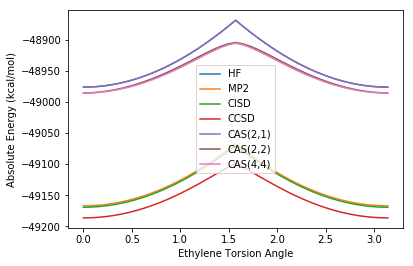

In [8]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Absolute Energy (kcal/mol)")
pylab.plot(angles, hartree_to_kcal * np.array(hf_energies), label="HF")
pylab.plot(angles, hartree_to_kcal * np.array(mp2_energies), label="MP2")
pylab.plot(angles, hartree_to_kcal * np.array(cisd_energies), label="CISD")
pylab.plot(angles, hartree_to_kcal * np.array(ccsd_energies), label="CCSD")
for key in cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * np.array(cas_energies[key]),
               label=key)
pylab.legend()

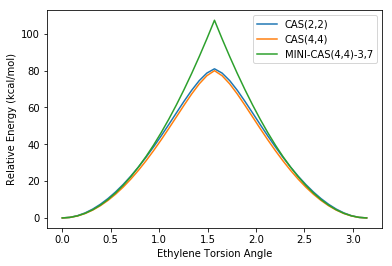

In [9]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Relative Energy (kcal/mol)")
for key in ['CAS(2,2)', 'CAS(4,4)']: #cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(cas_energies[key]) - cas_energies[key][0]),
              label=key)
for key in mini_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(mini_energies[key]) - mini_energies[key][0]),
               label="MINI-" + key)    
pylab.legend()
pylab.savefig("Ethylene__4_4_C1_MINI_8Qubit.pdf")

In [10]:
# Make a UCC Singlet Ansatz for CAS(4,4) at a particular geometry
uccsd_energies = {}
uccsd_amplitudes = {}
original_electrons = 16
for n_electrons, n_orbitals in [(4,4)]:#, (2,2)]:
    occupied_indices = range(8 - n_electrons // 2)
    active_indices = range(8 - n_electrons // 2, 8 - n_electrons // 2 + n_orbitals)
    active_electrons = original_electrons - len(occupied_indices) * 2
    active_qubits = len(active_indices) * 2

    # Define a qubit number operator
    number_operator = jordan_wigner(
        sum([FermionOperator( ((i, 1), (i, 0)), 1.0) for i in range(active_qubits)], FermionOperator()))
    number_operator.compress()
    spinz_operator = jordan_wigner(sum([FermionOperator( ((2*i, 1), (2*i, 0)), 0.5) 
                                        for i in range(active_qubits // 2)], FermionOperator()) +
                                   sum([FermionOperator( ((2*i+1, 1), (2*i+1, 0)), -0.5) 
                                        for i in range(active_qubits // 2)], FermionOperator()))
    spinz_operator.compress()
    
    n_amplitudes = int(uccsd_singlet_paramsize(active_qubits, 
                                           active_electrons))
    print("Running CAS({},{}) with {} coupled cluster amplitudes".format(n_electrons, n_orbitals,n_amplitudes))
    current_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
    uccsd_energies['CAS({},{})'.format(n_electrons, n_orbitals)] = []
    uccsd_amplitudes['CAS({},{})'.format(n_electrons, n_orbitals)] = []

    for file_index, filename in enumerate(molecule_filenames):
        print("Running CAS({},{}) on {}".format(n_electrons, n_orbitals, filename))
        molecule = MolecularData(filename=filename)
        # Extract active space integrals
        hamiltonian = (molecule.
                       get_molecular_hamiltonian(
                           occupied_indices=occupied_indices,
                           active_indices=active_indices))
        fermion_hamiltonian = get_fermion_operator(hamiltonian)


        # Use a Jordan-Wigner encoding, and compress to remove 0 imaginary components
        qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
        qubit_hamiltonian.compress()
        
        # Set standard UCCSD Compiler engine
        compiler_engine = uccsd_trotter_engine()

        def energy_objective(packed_amplitudes):
            """Evaluate the energy of a UCCSD singlet wavefunction with packed_amplitudes
            Args:
                packed_amplitudes(ndarray): Compact array that stores the unique
                    amplitudes for a UCCSD singlet wavefunction.

            Returns:
                energy(float): Energy corresponding to the given amplitudes
            """
            # Set Jordan-Wigner initial state with correct number of electrons
            wavefunction = compiler_engine.allocate_qureg(active_qubits)
            for i in range(active_electrons):
                X | wavefunction[i]

            # Build the circuit and act it on the wavefunction
            evolution_operator = uccsd_singlet_evolution(packed_amplitudes, 
                                                         active_qubits, 
                                                         active_electrons)
            evolution_operator | wavefunction
            compiler_engine.flush()

            # Evaluate the energy and reset wavefunction
            energy = compiler_engine.backend.get_expectation_value(qubit_hamiltonian, wavefunction)
            number = compiler_engine.backend.get_expectation_value(number_operator, wavefunction)
            spinz = compiler_engine.backend.get_expectation_value(spinz_operator, wavefunction)
            print("Energy: {}\t Number:{}\t Sz:{}".format(energy, number, spinz))
            All(Measure) | wavefunction
            compiler_engine.flush()
            return energy

        initial_energy = energy_objective(current_amplitudes)

        # Run VQE Optimization to find new CCSD parameters
        opt_result = minimize(energy_objective, current_amplitudes,
                              method="l-bfgs-b", options={'disp':True})

        opt_energy, opt_amplitudes = opt_result.fun, opt_result.x

        # Use previous interation as guess for next iteration
        current_amplitudes = opt_amplitudes[:]

        # Store energy and amplitudes
        uccsd_energies['CAS({},{})'.format(n_electrons, n_orbitals)].append(opt_energy)
        uccsd_amplitudes['CAS({},{})'.format(n_electrons, n_orbitals)].append([opt_amplitudes])

        print("\nInitial Energy: {}".format(initial_energy))
        print("Optimal UCCSD Singlet Energy: {}".format(opt_energy))
        print("Optimal UCCSD Singlet Amplitudes: {}".format(opt_amplitudes))
        print("Exact FCI Energy: {} Hartrees".format(
                cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)][file_index]))


Running CAS(4,4) with 20 coupled cluster amplitudes
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_0.00000.hdf5
Energy: -78.04915032726687	 Number:3.9999999999997122	 Sz:0.0
Energy: -78.04915032726687	 Number:3.9999999999997122	 Sz:0.0
Energy: -78.04915032727234	 Number:3.99999999999973	 Sz:0.0
Energy: -78.04915032727362	 Number:3.999999999999708	 Sz:0.0
Energy: -78.04915032726242	 Number:3.9999999999997184	 Sz:0.0
Energy: -78.04915032723507	 Number:3.9999999999997056	 Sz:0.0
Energy: -78.04915032770857	 Number:3.9999999999997087	 Sz:0.0
Energy: -78.04915032723339	 Number:3.9999999999997207	 Sz:0.0
Energy: -78.04915032722022	 Number:3.9999999999997127	 Sz:0.0
Energy: -78.04915032716762	 Number:3.999999999999714	 Sz:0.0
Energy: -78.04915032723339	 Number:3.9999999999997207	 Sz:0.0
Energy: -78.04915033085118	 Number:3.9999999999997145	 Sz:0.0
Energy: -78.04915032734588	 Number:3.9999999999996976	 Sz:0.0
Energy: -78.04915032728113	 Number:3.9999999999997105	 Sz:0.0
Energy: -78.0491503

Energy: -78.06396258796008	 Number:3.9999999999996967	 Sz:0.0
Energy: -78.06396258796056	 Number:3.9999999999997136	 Sz:0.0
Energy: -78.06396258795681	 Number:3.9999999999997002	 Sz:0.0
Energy: -78.06396258794526	 Number:3.9999999999997087	 Sz:0.0
Energy: -78.06396258794	 Number:3.999999999999703	 Sz:0.0
Energy: -78.06396258795868	 Number:3.999999999999719	 Sz:0.0
Energy: -78.06396258795876	 Number:3.9999999999997016	 Sz:0.0
Energy: -78.06396258795773	 Number:3.999999999999696	 Sz:0.0
Energy: -78.06396258795868	 Number:3.999999999999719	 Sz:0.0
Energy: -78.06396258795687	 Number:3.9999999999997047	 Sz:0.0
Energy: -78.06396258795932	 Number:3.999999999999711	 Sz:0.0
Energy: -78.06396258795723	 Number:3.9999999999996967	 Sz:0.0
Energy: -78.06396258795876	 Number:3.9999999999997016	 Sz:0.0
Energy: -78.06396258795932	 Number:3.999999999999711	 Sz:0.0
Energy: -78.06396258796498	 Number:3.9999999999997002	 Sz:0.0
Energy: -78.06396258795783	 Number:3.999999999999702	 Sz:0.0
Energy: -78.063962

Energy: -78.06353263519757	 Number:3.9999999999997273	 Sz:0.0
Energy: -78.06353263519186	 Number:3.999999999999743	 Sz:0.0
Energy: -78.06353263519271	 Number:3.999999999999737	 Sz:0.0
Energy: -78.06353263519757	 Number:3.9999999999997273	 Sz:0.0
Energy: -78.06353263519101	 Number:3.9999999999997256	 Sz:0.0
Energy: -78.06353804655247	 Number:3.999999999999745	 Sz:0.0
Energy: -78.06353804655278	 Number:3.9999999999997398	 Sz:0.0
Energy: -78.06353804655252	 Number:3.999999999999731	 Sz:0.0
Energy: -78.06353804655198	 Number:3.999999999999738	 Sz:0.0
Energy: -78.06353804654994	 Number:3.9999999999997415	 Sz:0.0
Energy: -78.06353804655286	 Number:3.999999999999727	 Sz:0.0
Energy: -78.06353804655186	 Number:3.9999999999997287	 Sz:0.0
Energy: -78.06353804655187	 Number:3.999999999999731	 Sz:0.0
Energy: -78.06353804655363	 Number:3.999999999999727	 Sz:0.0
Energy: -78.06353804655186	 Number:3.9999999999997287	 Sz:0.0
Energy: -78.06353804655214	 Number:3.999999999999746	 Sz:0.0
Energy: -78.06353

Energy: -78.06225852801383	 Number:3.9999999999997513	 Sz:0.0
Energy: -78.06225852796214	 Number:3.9999999999997295	 Sz:0.0
Energy: -78.0622585280024	 Number:3.9999999999997433	 Sz:0.0
Energy: -78.0622585280075	 Number:3.999999999999756	 Sz:0.0
Energy: -78.06225852801077	 Number:3.999999999999738	 Sz:0.0
Energy: -78.06225852801087	 Number:3.9999999999997513	 Sz:0.0
Energy: -78.0622585280075	 Number:3.999999999999756	 Sz:0.0
Energy: -78.06225852801334	 Number:3.9999999999997424	 Sz:0.0
Energy: -78.06225852801613	 Number:3.9999999999997344	 Sz:0.0
Energy: -78.06225852801383	 Number:3.9999999999997513	 Sz:0.0
Energy: -78.06225852801077	 Number:3.999999999999738	 Sz:0.0
Energy: -78.06225852801612	 Number:3.9999999999997327	 Sz:0.0
Energy: -78.06225852800755	 Number:3.999999999999746	 Sz:0.0
Energy: -78.06226373350775	 Number:3.999999999999766	 Sz:0.0
Energy: -78.06226373350813	 Number:3.999999999999772	 Sz:0.0
Energy: -78.06226373350799	 Number:3.999999999999769	 Sz:0.0
Energy: -78.0622637

Energy: -78.06014098193305	 Number:3.999999999999729	 Sz:0.0
Energy: -78.06014098193248	 Number:3.9999999999997033	 Sz:0.0
Energy: -78.06014098193296	 Number:3.9999999999997216	 Sz:0.0
Energy: -78.06014098193239	 Number:3.999999999999729	 Sz:0.0
Energy: -78.06014098189894	 Number:3.9999999999997153	 Sz:0.0
Energy: -78.06014098188972	 Number:3.9999999999997224	 Sz:0.0
Energy: -78.06014098193313	 Number:3.999999999999716	 Sz:0.0
Energy: -78.06014098193239	 Number:3.9999999999997393	 Sz:0.0
Energy: -78.06014098188984	 Number:3.9999999999997287	 Sz:0.0
Energy: -78.06014098192125	 Number:3.999999999999738	 Sz:0.0
Energy: -78.06014098193421	 Number:3.999999999999719	 Sz:0.0
Energy: -78.06014098193292	 Number:3.9999999999997256	 Sz:0.0
Energy: -78.06014098193313	 Number:3.999999999999716	 Sz:0.0
Energy: -78.06014098193421	 Number:3.999999999999719	 Sz:0.0
Energy: -78.06014098193852	 Number:3.999999999999722	 Sz:0.0
Energy: -78.06014098193836	 Number:3.999999999999723	 Sz:0.0
Energy: -78.06014

Energy: -77.38487259738814	 Number:3.999999999999687	 Sz:-8.326672684688674e-17
Energy: -77.38487259520821	 Number:3.9999999999996954	 Sz:-5.551115123125783e-17
Energy: -77.38487259517242	 Number:3.9999999999997016	 Sz:8.326672684688674e-17
Energy: -77.38487259738814	 Number:3.999999999999687	 Sz:-8.326672684688674e-17
Energy: -77.38487259247995	 Number:3.9999999999996962	 Sz:-2.7755575615628914e-17
Energy: -78.05718847754925	 Number:3.9999999999997673	 Sz:0.0
Energy: -78.05718847754909	 Number:3.999999999999756	 Sz:0.0
Energy: -78.05718847754875	 Number:3.9999999999997375	 Sz:0.0
Energy: -78.05718847754882	 Number:3.9999999999997424	 Sz:0.0
Energy: -78.05718847754872	 Number:3.9999999999997504	 Sz:0.0
Energy: -78.05718847750862	 Number:3.9999999999997504	 Sz:0.0
Energy: -78.05718847751118	 Number:3.9999999999997193	 Sz:0.0
Energy: -78.05718847754851	 Number:3.9999999999997438	 Sz:0.0
Energy: -78.05718847755486	 Number:3.9999999999997575	 Sz:0.0
Energy: -78.05718847751118	 Number:3.999

Energy: -78.05338340067725	 Number:3.999999999999721	 Sz:0.0
Energy: -78.05338340067729	 Number:3.9999999999997184	 Sz:0.0
Energy: -78.05338340067716	 Number:3.9999999999997273	 Sz:0.0
Energy: -78.05338340067132	 Number:3.9999999999997335	 Sz:0.0
Energy: -78.05338340067162	 Number:3.999999999999725	 Sz:0.0
Energy: -78.05338340067797	 Number:3.99999999999973	 Sz:0.0
Energy: -78.05338340067725	 Number:3.999999999999721	 Sz:0.0
Energy: -78.05338340067162	 Number:3.999999999999725	 Sz:0.0
Energy: -78.05338340068492	 Number:3.9999999999997287	 Sz:0.0
Energy: -77.35915595204241	 Number:3.9999999999997096	 Sz:-1.1102230246251565e-16
Energy: -77.35915595202847	 Number:3.9999999999997056	 Sz:-5.551115123125783e-17
Energy: -77.35915595204182	 Number:3.999999999999728	 Sz:-2.7755575615628914e-17
Energy: -77.3591559520383	 Number:3.9999999999997096	 Sz:-1.1102230246251565e-16
Energy: -77.35915595203197	 Number:3.999999999999722	 Sz:0.0
Energy: -77.35915594834461	 Number:3.9999999999997176	 Sz:0.0


Energy: -78.04880319165933	 Number:3.9999999999997353	 Sz:0.0
Energy: -78.04880319173617	 Number:3.9999999999997353	 Sz:0.0
Energy: -78.048803191759	 Number:3.9999999999997407	 Sz:0.0
Energy: -78.0488031916591	 Number:3.999999999999739	 Sz:0.0
Energy: -78.04880319165838	 Number:3.9999999999997318	 Sz:0.0
Energy: -78.0488031917589	 Number:3.9999999999997335	 Sz:0.0
Energy: -78.04880319171423	 Number:3.9999999999997433	 Sz:0.0
Energy: -78.04880319166016	 Number:3.9999999999997335	 Sz:0.0
Energy: -78.04880319165932	 Number:3.999999999999751	 Sz:0.0
Energy: -78.0488031916591	 Number:3.999999999999739	 Sz:0.0
Energy: -78.04880319166016	 Number:3.9999999999997335	 Sz:0.0
Energy: -78.04880319165215	 Number:3.999999999999746	 Sz:0.0
Energy: -78.04880319165486	 Number:3.9999999999997495	 Sz:0.0
Energy: -78.04880319165838	 Number:3.9999999999997318	 Sz:0.0
Energy: -78.04880319165932	 Number:3.999999999999751	 Sz:0.0
Energy: -78.04880319165486	 Number:3.9999999999997495	 Sz:0.0
Energy: -78.048803

Energy: -78.0434296378879	 Number:3.99999999999974	 Sz:0.0
Energy: -78.04342963788818	 Number:3.9999999999997513	 Sz:0.0
Energy: -78.04342963788822	 Number:3.999999999999759	 Sz:0.0
Energy: -78.04342963788794	 Number:3.999999999999747	 Sz:0.0
Energy: -78.04342963788818	 Number:3.999999999999757	 Sz:0.0
Energy: -78.04342963796442	 Number:3.9999999999997398	 Sz:0.0
Energy: -78.04342963797389	 Number:3.999999999999744	 Sz:0.0
Energy: -78.0434296378879	 Number:3.9999999999997553	 Sz:0.0
Energy: -78.04342963788818	 Number:3.99999999999975	 Sz:0.0
Energy: -78.0434296379738	 Number:3.9999999999997393	 Sz:0.0
Energy: -78.04342963796375	 Number:3.9999999999997478	 Sz:0.0
Energy: -78.04342963788771	 Number:3.999999999999747	 Sz:0.0
Energy: -78.04342963788753	 Number:3.999999999999719	 Sz:0.0
Energy: -78.0434296378879	 Number:3.9999999999997553	 Sz:0.0
Energy: -78.04342963788771	 Number:3.999999999999747	 Sz:0.0
Energy: -78.04342963787938	 Number:3.999999999999738	 Sz:0.0
Energy: -78.043429637883

Energy: -78.03728436051921	 Number:3.9999999999997278	 Sz:0.0
Energy: -78.03728436051107	 Number:3.9999999999997184	 Sz:0.0
Energy: -78.03728436051094	 Number:3.9999999999997153	 Sz:0.0
Energy: -78.03728436051058	 Number:3.999999999999718	 Sz:0.0
Energy: -78.03728436051436	 Number:3.9999999999997207	 Sz:0.0
Energy: -78.03728436051094	 Number:3.9999999999997153	 Sz:0.0
Energy: -78.03728436052334	 Number:3.999999999999712	 Sz:0.0
Energy: -77.33746870464233	 Number:3.999999999999689	 Sz:5.551115123125783e-17
Energy: -77.33746870460674	 Number:3.9999999999996954	 Sz:8.326672684688674e-17
Energy: -77.33746870463195	 Number:3.99999999999969	 Sz:-2.7755575615628914e-17
Energy: -77.33746870464488	 Number:3.99999999999969	 Sz:0.0
Energy: -77.33746870464256	 Number:3.9999999999996985	 Sz:-2.7755575615628914e-17
Energy: -77.33746870062481	 Number:3.999999999999691	 Sz:0.0
Energy: -77.33746870444313	 Number:3.9999999999996967	 Sz:-2.7755575615628914e-17
Energy: -77.33746870462888	 Number:3.9999999

Energy: -78.03039379323296	 Number:3.999999999999731	 Sz:0.0
Energy: -78.03039379323226	 Number:3.999999999999716	 Sz:0.0
Energy: -78.0303937932988	 Number:3.9999999999997238	 Sz:0.0
Energy: -78.03039379335698	 Number:3.9999999999997247	 Sz:0.0
Energy: -78.03039379323349	 Number:3.9999999999997455	 Sz:0.0
Energy: -78.0303937932328	 Number:3.9999999999997287	 Sz:0.0
Energy: -78.03039379323296	 Number:3.999999999999731	 Sz:0.0
Energy: -78.03039379323349	 Number:3.9999999999997455	 Sz:0.0
Energy: -78.03039379322651	 Number:3.9999999999997184	 Sz:0.0
Energy: -78.03039379322988	 Number:3.9999999999997096	 Sz:0.0
Energy: -78.03039379323226	 Number:3.999999999999716	 Sz:0.0
Energy: -78.0303937932328	 Number:3.9999999999997287	 Sz:0.0
Energy: -78.03039379322988	 Number:3.9999999999997096	 Sz:0.0
Energy: -78.03039379324262	 Number:3.9999999999997247	 Sz:0.0
Energy: -77.35846218256891	 Number:3.9999999999996936	 Sz:1.1102230246251565e-16
Energy: -77.35846218257895	 Number:3.999999999999688	 Sz:2

Energy: -78.02279250941935	 Number:3.999999999999726	 Sz:0.0
Energy: -78.02279250941939	 Number:3.9999999999997313	 Sz:0.0
Energy: -78.02279250941946	 Number:3.9999999999997353	 Sz:0.0
Energy: -78.02279250941959	 Number:3.99999999999973	 Sz:0.0
Energy: -78.02279250941938	 Number:3.9999999999997313	 Sz:0.0
Energy: -78.02279250948497	 Number:3.9999999999997464	 Sz:0.0
Energy: -78.0227925094772	 Number:3.999999999999692	 Sz:0.0
Energy: -78.022792509419	 Number:3.9999999999997264	 Sz:0.0
Energy: -78.02279250942173	 Number:3.9999999999997464	 Sz:0.0
Energy: -78.0227925094772	 Number:3.999999999999692	 Sz:0.0
Energy: -78.02279250956674	 Number:3.9999999999997238	 Sz:0.0
Energy: -78.0227925094168	 Number:3.9999999999997238	 Sz:0.0
Energy: -78.02279250941899	 Number:3.9999999999997065	 Sz:0.0
Energy: -78.022792509419	 Number:3.9999999999997264	 Sz:0.0
Energy: -78.0227925094168	 Number:3.9999999999997238	 Sz:0.0
Energy: -78.02279250941133	 Number:3.9999999999997327	 Sz:0.0
Energy: -78.022792509

Energy: -78.02283691512362	 Number:3.9999999999997273	 Sz:0.0
Energy: -78.02283691512345	 Number:3.9999999999997167	 Sz:0.0
Energy: -78.02283691512315	 Number:3.9999999999997113	 Sz:0.0
Energy: -78.02283691512464	 Number:3.999999999999725	 Sz:0.0
Energy: -78.02283691512099	 Number:3.9999999999997367	 Sz:0.0
Energy: -78.02283691512365	 Number:3.999999999999732	 Sz:0.0
Energy: -78.0228369151234	 Number:3.9999999999997207	 Sz:0.0
Energy: -78.02283691512099	 Number:3.9999999999997367	 Sz:0.0
Energy: -78.02283691512476	 Number:3.999999999999724	 Sz:0.0
Energy: -78.0228369151237	 Number:3.999999999999729	 Sz:0.0
Energy: -78.0228369151238	 Number:3.999999999999742	 Sz:0.0
Energy: -78.02283691512365	 Number:3.999999999999732	 Sz:0.0
Energy: -78.0228369151237	 Number:3.999999999999729	 Sz:0.0
Energy: -78.02283691512311	 Number:3.9999999999997327	 Sz:0.0
Energy: -78.02283691512365	 Number:3.9999999999997295	 Sz:0.0
Energy: -78.0228369151234	 Number:3.9999999999997207	 Sz:0.0
Energy: -78.02283691

Energy: -78.01458292285155	 Number:3.9999999999997478	 Sz:0.0
Energy: -78.01458292286183	 Number:3.9999999999997278	 Sz:0.0
Energy: -78.01458292285604	 Number:3.999999999999731	 Sz:0.0
Energy: -78.01458292286144	 Number:3.9999999999997344	 Sz:0.0
Energy: -78.01458292285714	 Number:3.9999999999997344	 Sz:0.0
Energy: -78.01458292285604	 Number:3.999999999999731	 Sz:0.0
Energy: -78.0145829228574	 Number:3.999999999999738	 Sz:0.0
Energy: -78.01458295641245	 Number:3.9999999999997273	 Sz:0.0
Energy: -78.01458295641247	 Number:3.999999999999718	 Sz:0.0
Energy: -78.01458295641228	 Number:3.999999999999712	 Sz:0.0
Energy: -78.01458295641216	 Number:3.99999999999971	 Sz:0.0
Energy: -78.01458295641234	 Number:3.999999999999714	 Sz:0.0
Energy: -78.01458295641149	 Number:3.9999999999997162	 Sz:0.0
Energy: -78.01458295641208	 Number:3.9999999999997176	 Sz:0.0
Energy: -78.0145829564125	 Number:3.9999999999997327	 Sz:0.0
Energy: -78.01458295640877	 Number:3.999999999999732	 Sz:0.0
Energy: -78.0145829

Energy: -78.00572499751821	 Number:3.9999999999997264	 Sz:0.0
Energy: -78.00572499751968	 Number:3.999999999999714	 Sz:0.0
Energy: -78.00572499751242	 Number:3.999999999999711	 Sz:0.0
Energy: -78.00572499752397	 Number:3.9999999999997247	 Sz:0.0
Energy: -78.00572499751638	 Number:3.9999999999997216	 Sz:0.0
Energy: -78.00572499751848	 Number:3.9999999999997247	 Sz:0.0
Energy: -78.00572499751821	 Number:3.9999999999997264	 Sz:0.0
Energy: -78.00572499751637	 Number:3.999999999999722	 Sz:0.0
Energy: -78.00572499751561	 Number:3.999999999999714	 Sz:0.0
Energy: -78.00572499751851	 Number:3.999999999999719	 Sz:0.0
Energy: -78.00572499751968	 Number:3.999999999999714	 Sz:0.0
Energy: -78.00572499751848	 Number:3.9999999999997247	 Sz:0.0
Energy: -78.0057249975185	 Number:3.999999999999718	 Sz:0.0
Energy: -78.00572499752155	 Number:3.99999999999972	 Sz:0.0
Energy: -78.00572513307226	 Number:3.9999999999996905	 Sz:0.0
Energy: -78.00572513307287	 Number:3.999999999999716	 Sz:0.0
Energy: -78.0057251

Energy: -77.9963413967457	 Number:3.9999999999997415	 Sz:0.0
Energy: -77.99634272633449	 Number:3.9999999999997335	 Sz:0.0
Energy: -77.99634272633433	 Number:3.999999999999739	 Sz:0.0
Energy: -77.99634272633426	 Number:3.999999999999731	 Sz:0.0
Energy: -77.99634272633462	 Number:3.9999999999997407	 Sz:0.0
Energy: -77.9963427263341	 Number:3.999999999999718	 Sz:0.0
Energy: -77.99634272634296	 Number:3.999999999999714	 Sz:0.0
Energy: -77.99634272633334	 Number:3.9999999999997367	 Sz:0.0
Energy: -77.99634272633652	 Number:3.999999999999732	 Sz:0.0
Energy: -77.99634272630624	 Number:3.999999999999724	 Sz:0.0
Energy: -77.99634272633334	 Number:3.9999999999997367	 Sz:0.0
Energy: -77.99634272633477	 Number:3.999999999999728	 Sz:0.0
Energy: -77.99634272636422	 Number:3.9999999999997247	 Sz:0.0
Energy: -77.99634272633287	 Number:3.9999999999997287	 Sz:0.0
Energy: -77.99634272633652	 Number:3.999999999999732	 Sz:0.0
Energy: -77.99634272636425	 Number:3.999999999999727	 Sz:0.0
Energy: -77.9963427

Energy: -77.98653362388127	 Number:3.999999999999731	 Sz:0.0
Energy: -77.98653362388072	 Number:3.9999999999997327	 Sz:0.0
Energy: -77.98653362388158	 Number:3.999999999999752	 Sz:0.0
Energy: -77.98653362388937	 Number:3.999999999999741	 Sz:0.0
Energy: -77.98653362387897	 Number:3.9999999999997393	 Sz:0.0
Energy: -77.98653362388015	 Number:3.9999999999997353	 Sz:0.0
Energy: -77.98653362388127	 Number:3.999999999999731	 Sz:0.0
Energy: -77.98653362387897	 Number:3.9999999999997393	 Sz:0.0
Energy: -77.98653362385508	 Number:3.9999999999997384	 Sz:0.0
Energy: -77.98654631660935	 Number:3.99999999999973	 Sz:0.0
Energy: -77.9865463166091	 Number:3.9999999999997073	 Sz:0.0
Energy: -77.98654631660908	 Number:3.999999999999713	 Sz:0.0
Energy: -77.98654631660924	 Number:3.999999999999717	 Sz:0.0
Energy: -77.98654631660912	 Number:3.999999999999718	 Sz:0.0
Energy: -77.986546316672	 Number:3.9999999999997202	 Sz:0.0
Energy: -77.98654631660808	 Number:3.9999999999997087	 Sz:0.0
Energy: -77.98654631

Energy: -77.61245038253448	 Number:3.999999999999723	 Sz:-5.551115123125783e-17
Energy: -77.61245037951142	 Number:3.999999999999717	 Sz:0.0
Energy: -77.61245038402498	 Number:3.9999999999997065	 Sz:-8.326672684688674e-17
Energy: -77.61245038291464	 Number:3.999999999999708	 Sz:-1.3877787807814457e-16
Energy: -77.61245038275305	 Number:3.999999999999714	 Sz:-5.551115123125783e-17
Energy: -77.6124503827712	 Number:3.99999999999971	 Sz:-2.7755575615628914e-17
Energy: -77.61245038291447	 Number:3.999999999999699	 Sz:-8.326672684688674e-17
Energy: -77.6124503824449	 Number:3.9999999999997033	 Sz:0.0
Energy: -77.61245038309768	 Number:3.999999999999707	 Sz:-5.551115123125783e-17
Energy: -77.61245038253445	 Number:3.999999999999721	 Sz:-1.3877787807814457e-16
Energy: -77.61245038275305	 Number:3.999999999999714	 Sz:-5.551115123125783e-17
Energy: -77.61245038309768	 Number:3.999999999999707	 Sz:-5.551115123125783e-17
Energy: -77.61245038234489	 Number:3.9999999999997002	 Sz:-8.326672684688674

Energy: -77.9660798639453	 Number:3.9999999999997264	 Sz:0.0
Energy: -77.96607986394501	 Number:3.9999999999997233	 Sz:0.0
Energy: -77.96607986394511	 Number:3.999999999999716	 Sz:0.0
Energy: -77.96607986397903	 Number:3.9999999999997184	 Sz:0.0
Energy: -77.96607986399579	 Number:3.999999999999735	 Sz:0.0
Energy: -77.96607986394508	 Number:3.9999999999997207	 Sz:0.0
Energy: -77.96607986394493	 Number:3.999999999999719	 Sz:0.0
Energy: -77.96607986399579	 Number:3.999999999999735	 Sz:0.0
Energy: -77.96607986429686	 Number:3.999999999999715	 Sz:0.0
Energy: -77.96607986394588	 Number:3.9999999999997247	 Sz:0.0
Energy: -77.96607986394491	 Number:3.9999999999997162	 Sz:0.0
Energy: -77.96607986394508	 Number:3.9999999999997207	 Sz:0.0
Energy: -77.96607986394594	 Number:3.9999999999997273	 Sz:0.0
Energy: -77.96607986394119	 Number:3.9999999999997256	 Sz:0.0
Energy: -77.96607986394486	 Number:3.999999999999722	 Sz:0.0
Energy: -77.96607986394493	 Number:3.999999999999719	 Sz:0.0
Energy: -77.9660

Energy: -77.96645693306206	 Number:3.999999999999741	 Sz:0.0
Energy: -77.96645693306525	 Number:3.9999999999997247	 Sz:0.0
Energy: -77.966456933067	 Number:3.9999999999997184	 Sz:0.0
Energy: -77.96645693306843	 Number:3.999999999999744	 Sz:0.0
Energy: -77.96645693306525	 Number:3.9999999999997247	 Sz:0.0
Energy: -77.96645693306822	 Number:3.999999999999735	 Sz:0.0
Energy: -77.96645693306644	 Number:3.99999999999974	 Sz:0.0
Energy: -77.9664569330675	 Number:3.9999999999997455	 Sz:0.0
Energy: -77.966456933067	 Number:3.9999999999997184	 Sz:0.0
Energy: -77.96645693306644	 Number:3.99999999999974	 Sz:0.0
Energy: -77.96645693307774	 Number:3.9999999999997455	 Sz:0.0
Energy: -77.96645693306553	 Number:3.99999999999975	 Sz:0.0
Energy: -77.96645693306843	 Number:3.999999999999744	 Sz:0.0
Energy: -77.9664569330675	 Number:3.9999999999997455	 Sz:0.0
Energy: -77.96645693306553	 Number:3.99999999999975	 Sz:0.0
Energy: -77.9664569330672	 Number:3.999999999999744	 Sz:0.0
Energy: -77.96645702573778	 

Energy: -77.95671321912728	 Number:3.999999999999699	 Sz:0.0
Energy: -77.9567132191391	 Number:3.9999999999997238	 Sz:0.0
Energy: -77.95671321918155	 Number:3.9999999999997122	 Sz:0.0
Energy: -77.95675730953765	 Number:3.999999999999709	 Sz:0.0
Energy: -77.95675730953779	 Number:3.999999999999715	 Sz:0.0
Energy: -77.95675730953755	 Number:3.9999999999997007	 Sz:0.0
Energy: -77.95675730953793	 Number:3.999999999999721	 Sz:0.0
Energy: -77.95675730953768	 Number:3.999999999999707	 Sz:0.0
Energy: -77.95675730954669	 Number:3.999999999999703	 Sz:0.0
Energy: -77.95675730954082	 Number:3.999999999999703	 Sz:0.0
Energy: -77.95675730953182	 Number:3.9999999999997216	 Sz:0.0
Energy: -77.95675730961376	 Number:3.9999999999997082	 Sz:0.0
Energy: -77.95675730954082	 Number:3.999999999999703	 Sz:0.0
Energy: -77.95675730953509	 Number:3.9999999999997176	 Sz:0.0
Energy: -77.9567573094626	 Number:3.9999999999997162	 Sz:0.0
Energy: -77.95675730954154	 Number:3.9999999999997122	 Sz:0.0
Energy: -77.956757

Energy: -77.71492930942392	 Number:3.9999999999997176	 Sz:-2.7755575615628914e-17
Energy: -77.71492930938979	 Number:3.999999999999716	 Sz:-1.1102230246251565e-16
Energy: -77.71492930943451	 Number:3.999999999999729	 Sz:2.7755575615628914e-17
Energy: -77.71492931007083	 Number:3.9999999999997207	 Sz:-1.1102230246251565e-16
Energy: -77.71492930941686	 Number:3.999999999999721	 Sz:2.7755575615628914e-17
Energy: -77.71492930938759	 Number:3.9999999999997136	 Sz:0.0
Energy: -77.71492930942392	 Number:3.9999999999997176	 Sz:-2.7755575615628914e-17
Energy: -77.71492930941686	 Number:3.999999999999721	 Sz:2.7755575615628914e-17
Energy: -77.7149293092126	 Number:3.999999999999725	 Sz:0.0
Energy: -77.9478855684398	 Number:3.9999999999997136	 Sz:0.0
Energy: -77.94788556843953	 Number:3.9999999999997167	 Sz:0.0
Energy: -77.9478855684401	 Number:3.9999999999997278	 Sz:0.0
Energy: -77.9478855684397	 Number:3.9999999999997096	 Sz:0.0
Energy: -77.94788556843994	 Number:3.999999999999716	 Sz:0.0
Energ

Energy: -77.94798516574068	 Number:3.9999999999997304	 Sz:0.0
Energy: -77.94798516574262	 Number:3.9999999999997247	 Sz:0.0
Energy: -77.94798516574248	 Number:3.99999999999973	 Sz:0.0
Energy: -77.94798516574411	 Number:3.9999999999997224	 Sz:0.0
Energy: -77.94798517400196	 Number:3.999999999999727	 Sz:0.0
Energy: -77.94798517400189	 Number:3.9999999999997287	 Sz:0.0
Energy: -77.9479851740019	 Number:3.999999999999725	 Sz:0.0
Energy: -77.94798517400223	 Number:3.9999999999997327	 Sz:0.0
Energy: -77.94798517400213	 Number:3.9999999999997318	 Sz:0.0
Energy: -77.94798517400083	 Number:3.999999999999713	 Sz:0.0
Energy: -77.9479851740017	 Number:3.9999999999997238	 Sz:0.0
Energy: -77.94798517400187	 Number:3.9999999999997393	 Sz:0.0
Energy: -77.94798517400221	 Number:3.999999999999746	 Sz:0.0
Energy: -77.94798517400146	 Number:3.9999999999997127	 Sz:0.0
Energy: -77.94798517400186	 Number:3.9999999999997318	 Sz:0.0
Energy: -77.94798517400193	 Number:3.999999999999738	 Sz:0.0
Energy: -77.94798

Energy: -77.94090816678568	 Number:3.99999999999969	 Sz:0.0
Energy: -77.94090816678614	 Number:3.999999999999704	 Sz:5.551115123125783e-17
Energy: -77.94090816678579	 Number:3.9999999999997	 Sz:-2.7755575615628914e-17
Energy: -77.94090816678585	 Number:3.999999999999703	 Sz:2.7755575615628914e-17
Energy: -77.94090816678585	 Number:3.999999999999704	 Sz:-5.551115123125783e-17
Energy: -77.94090816688362	 Number:3.999999999999703	 Sz:1.1102230246251565e-16
Energy: -77.94090816675903	 Number:3.9999999999997065	 Sz:1.3877787807814457e-16
Energy: -77.9409081667856	 Number:3.999999999999693	 Sz:8.326672684688674e-17
Energy: -77.94090816679042	 Number:3.9999999999997047	 Sz:0.0
Energy: -77.94090816675906	 Number:3.999999999999707	 Sz:8.326672684688674e-17
Energy: -77.94090816682203	 Number:3.9999999999996914	 Sz:5.551115123125783e-17
Energy: -77.94090816678204	 Number:3.9999999999997202	 Sz:-5.551115123125783e-17
Energy: -77.94090816678553	 Number:3.999999999999675	 Sz:2.7755575615628914e-17
E

Energy: -77.93477690868542	 Number:3.999999999999696	 Sz:-5.551115123125783e-17
Energy: -77.93477690868565	 Number:3.9999999999996985	 Sz:-8.326672684688674e-17
Energy: -77.93477690868538	 Number:3.999999999999696	 Sz:-1.1102230246251565e-16
Energy: -77.9347769086852	 Number:3.999999999999692	 Sz:-5.551115123125783e-17
Energy: -77.93477690868534	 Number:3.9999999999996976	 Sz:-8.326672684688674e-17
Energy: -77.93477690869749	 Number:3.999999999999695	 Sz:0.0
Energy: -77.93477690872734	 Number:3.999999999999685	 Sz:2.7755575615628914e-17
Energy: -77.93477690868508	 Number:3.999999999999687	 Sz:-5.551115123125783e-17
Energy: -77.93477690868508	 Number:3.999999999999692	 Sz:-1.6653345369377348e-16
Energy: -77.93477690872734	 Number:3.999999999999685	 Sz:2.7755575615628914e-17
Energy: -77.93477690929387	 Number:3.9999999999996967	 Sz:-8.326672684688674e-17
Energy: -77.93477690868522	 Number:3.9999999999997047	 Sz:-1.3877787807814457e-16
Energy: -77.9347769086859	 Number:3.9999999999997184	

Energy: -77.93657796918279	 Number:3.9999999999997455	 Sz:0.0
Energy: -77.93657796918309	 Number:3.9999999999997446	 Sz:1.3877787807814457e-16
Energy: -77.93657796918313	 Number:3.999999999999743	 Sz:8.326672684688674e-17
Energy: -77.93657796918258	 Number:3.9999999999997184	 Sz:5.551115123125783e-17
Energy: -77.93657796915943	 Number:3.9999999999997335	 Sz:0.0
Energy: -77.93657796919346	 Number:3.9999999999997375	 Sz:2.7755575615628914e-17
Energy: -77.93657796918471	 Number:3.9999999999997167	 Sz:-2.7755575615628914e-17
Energy: -77.93657796920085	 Number:3.9999999999997327	 Sz:1.1102230246251565e-16
Energy: -77.93657796919346	 Number:3.9999999999997375	 Sz:2.7755575615628914e-17
Energy: -77.93657796917626	 Number:3.999999999999725	 Sz:8.326672684688674e-17
Energy: -77.9365779691673	 Number:3.999999999999725	 Sz:1.3877787807814457e-16
Energy: -77.93657796918306	 Number:3.999999999999725	 Sz:1.3877787807814457e-16
Energy: -77.93657796918471	 Number:3.9999999999997167	 Sz:-2.775557561562

Energy: -77.9389734811726	 Number:3.9999999999996954	 Sz:2.7755575615628914e-17
Energy: -77.938973481169	 Number:3.9999999999997016	 Sz:-2.7755575615628914e-17
Energy: -77.9389734811692	 Number:3.9999999999997082	 Sz:2.7755575615628914e-17
Energy: -77.93897348116893	 Number:3.9999999999997025	 Sz:2.7755575615628914e-17
Energy: -77.938973481169	 Number:3.9999999999997016	 Sz:-2.7755575615628914e-17
Energy: -77.93897348116434	 Number:3.999999999999696	 Sz:1.3877787807814457e-16
Energy: -77.80296647982483	 Number:3.99999999999975	 Sz:-2.7755575615628914e-17
Energy: -77.80296647982613	 Number:3.999999999999745	 Sz:-2.7755575615628914e-17
Energy: -77.80296647982466	 Number:3.9999999999997464	 Sz:0.0
Energy: -77.80296647981835	 Number:3.99999999999975	 Sz:0.0
Energy: -77.80296647982132	 Number:3.9999999999997446	 Sz:2.7755575615628914e-17
Energy: -77.80296648140515	 Number:3.99999999999974	 Sz:2.7755575615628914e-17
Energy: -77.80296648127369	 Number:3.9999999999997318	 Sz:0.0
Energy: -77.80

Energy: -77.94092300091137	 Number:3.9999999999997287	 Sz:-2.7755575615628914e-17
Energy: -77.94092394621684	 Number:3.999999999999708	 Sz:-2.7755575615628914e-17
Energy: -77.94092394621742	 Number:3.999999999999727	 Sz:2.7755575615628914e-17
Energy: -77.94092394621708	 Number:3.999999999999709	 Sz:0.0
Energy: -77.9409239462169	 Number:3.999999999999707	 Sz:1.3877787807814457e-16
Energy: -77.9409239462172	 Number:3.999999999999723	 Sz:1.3877787807814457e-16
Energy: -77.94092394622967	 Number:3.999999999999695	 Sz:2.7755575615628914e-17
Energy: -77.94092394621512	 Number:3.9999999999996967	 Sz:1.1102230246251565e-16
Energy: -77.94092394621829	 Number:3.999999999999722	 Sz:1.6653345369377348e-16
Energy: -77.94092394621325	 Number:3.999999999999715	 Sz:0.0
Energy: -77.94092394621512	 Number:3.9999999999996967	 Sz:1.1102230246251565e-16
Energy: -77.94092394622085	 Number:3.9999999999997073	 Sz:8.326672684688674e-17
Energy: -77.94092394622089	 Number:3.999999999999711	 Sz:8.326672684688674e

Energy: -77.79249509819948	 Number:3.9999999999997096	 Sz:-2.7755575615628914e-17
Energy: -77.7924950987702	 Number:3.999999999999715	 Sz:0.0
Energy: -77.79249509898726	 Number:3.999999999999703	 Sz:0.0
Energy: -77.7924950987417	 Number:3.999999999999706	 Sz:2.7755575615628914e-17
Energy: -77.7924950987702	 Number:3.999999999999715	 Sz:0.0
Energy: -77.79249509881967	 Number:3.9999999999997025	 Sz:2.7755575615628914e-17
Energy: -77.94786479176624	 Number:3.9999999999997358	 Sz:0.0
Energy: -77.94786479176624	 Number:3.999999999999731	 Sz:0.0
Energy: -77.94786479176658	 Number:3.9999999999997504	 Sz:0.0
Energy: -77.94786479176659	 Number:3.9999999999997438	 Sz:0.0
Energy: -77.94786479176645	 Number:3.9999999999997518	 Sz:0.0
Energy: -77.94786479192969	 Number:3.9999999999997287	 Sz:0.0
Energy: -77.94786479190456	 Number:3.999999999999742	 Sz:0.0
Energy: -77.94786479176442	 Number:3.999999999999715	 Sz:0.0
Energy: -77.9478647917784	 Number:3.999999999999744	 Sz:0.0
Energy: -77.947864791904

Energy: -77.9479851549654	 Number:3.999999999999746	 Sz:0.0
Energy: -77.94798515496512	 Number:3.9999999999997393	 Sz:0.0
Energy: -77.94798515496484	 Number:3.9999999999997398	 Sz:0.0
Energy: -77.94798515496495	 Number:3.99999999999974	 Sz:0.0
Energy: -77.94798515496534	 Number:3.9999999999997544	 Sz:0.0
Energy: -77.94798515496676	 Number:3.9999999999997486	 Sz:0.0
Energy: -77.94798515496507	 Number:3.9999999999997407	 Sz:0.0
Energy: -77.94798515496596	 Number:3.9999999999997398	 Sz:0.0
Energy: -77.94798515496676	 Number:3.9999999999997486	 Sz:0.0
Energy: -77.94798515496642	 Number:3.999999999999742	 Sz:0.0
Energy: -77.94798515496538	 Number:3.9999999999997438	 Sz:0.0
Energy: -77.94798515496532	 Number:3.999999999999748	 Sz:0.0
Energy: -77.94798515496507	 Number:3.9999999999997407	 Sz:0.0
Energy: -77.94798515496538	 Number:3.9999999999997438	 Sz:0.0
Energy: -77.94798515496844	 Number:3.999999999999745	 Sz:0.0
Energy: -77.94798515496552	 Number:3.999999999999758	 Sz:0.0
Energy: -77.9479

Energy: -77.95666565219177	 Number:3.9999999999997367	 Sz:0.0
Energy: -77.95666565222211	 Number:3.9999999999997162	 Sz:0.0
Energy: -77.95666565220397	 Number:3.999999999999726	 Sz:0.0
Energy: -77.95666565214995	 Number:3.999999999999719	 Sz:0.0
Energy: -77.95675811141183	 Number:3.9999999999997393	 Sz:0.0
Energy: -77.95675811141193	 Number:3.9999999999997384	 Sz:0.0
Energy: -77.95675811141142	 Number:3.999999999999716	 Sz:0.0
Energy: -77.95675811141166	 Number:3.9999999999997256	 Sz:0.0
Energy: -77.95675811141113	 Number:3.9999999999997113	 Sz:0.0
Energy: -77.95675811135662	 Number:3.9999999999997233	 Sz:0.0
Energy: -77.9567581114366	 Number:3.9999999999997295	 Sz:0.0
Energy: -77.95675811141257	 Number:3.999999999999727	 Sz:0.0
Energy: -77.9567581113984	 Number:3.9999999999997438	 Sz:0.0
Energy: -77.9567581114366	 Number:3.9999999999997295	 Sz:0.0
Energy: -77.95675811139374	 Number:3.9999999999997216	 Sz:0.0
Energy: -77.95675811142432	 Number:3.9999999999997096	 Sz:0.0
Energy: -77.956

Energy: -77.96580577709183	 Number:3.9999999999997407	 Sz:0.0
Energy: -77.96580577708878	 Number:3.999999999999735	 Sz:0.0
Energy: -77.96580577708798	 Number:3.999999999999734	 Sz:0.0
Energy: -77.96580577708808	 Number:3.9999999999997393	 Sz:0.0
Energy: -77.96580577708878	 Number:3.999999999999735	 Sz:0.0
Energy: -77.96580577707694	 Number:3.9999999999997313	 Sz:0.0
Energy: -77.75518321885698	 Number:3.9999999999997153	 Sz:0.0
Energy: -77.7551832188525	 Number:3.9999999999997278	 Sz:0.0
Energy: -77.75518321885566	 Number:3.99999999999972	 Sz:0.0
Energy: -77.75518321886028	 Number:3.999999999999723	 Sz:0.0
Energy: -77.75518321885622	 Number:3.9999999999997202	 Sz:0.0
Energy: -77.75518322131596	 Number:3.9999999999997162	 Sz:0.0
Energy: -77.75518322101902	 Number:3.9999999999997047	 Sz:0.0
Energy: -77.75518321888303	 Number:3.999999999999716	 Sz:0.0
Energy: -77.75518321887957	 Number:3.999999999999715	 Sz:2.7755575615628914e-17
Energy: -77.75518322101902	 Number:3.9999999999997047	 Sz:0.

Energy: -77.97608501783074	 Number:3.9999999999997518	 Sz:0.0
Energy: -77.97608501783063	 Number:3.999999999999746	 Sz:0.0
Energy: -77.97608501783071	 Number:3.9999999999997486	 Sz:0.0
Energy: -77.97608501783074	 Number:3.999999999999748	 Sz:0.0
Energy: -77.97608501783107	 Number:3.999999999999759	 Sz:0.0
Energy: -77.97608501780599	 Number:3.9999999999997566	 Sz:0.0
Energy: -77.97608501777613	 Number:3.9999999999997544	 Sz:0.0
Energy: -77.97608501783196	 Number:3.999999999999752	 Sz:0.0
Energy: -77.97608501781653	 Number:3.9999999999997407	 Sz:0.0
Energy: -77.97608501777613	 Number:3.9999999999997544	 Sz:0.0
Energy: -77.97608501743477	 Number:3.999999999999743	 Sz:0.0
Energy: -77.97608501784498	 Number:3.99999999999975	 Sz:0.0
Energy: -77.97608501783054	 Number:3.9999999999997566	 Sz:0.0
Energy: -77.97608501783196	 Number:3.999999999999752	 Sz:0.0
Energy: -77.97608501784498	 Number:3.99999999999975	 Sz:0.0
Energy: -77.97608501783978	 Number:3.9999999999997575	 Sz:0.0
Energy: -77.976085

Energy: -77.97650785311029	 Number:3.9999999999997358	 Sz:0.0
Energy: -77.97650785310445	 Number:3.999999999999727	 Sz:0.0
Energy: -77.97650785311183	 Number:3.9999999999997313	 Sz:0.0
Energy: -77.97650785311144	 Number:3.9999999999997486	 Sz:0.0
Energy: -77.97650785311082	 Number:3.9999999999997335	 Sz:0.0
Energy: -77.97650785311183	 Number:3.9999999999997313	 Sz:0.0
Energy: -77.97650785310915	 Number:3.9999999999997486	 Sz:0.0
Energy: -77.97650785311097	 Number:3.9999999999997393	 Sz:0.0
Energy: -77.97650785311085	 Number:3.9999999999997393	 Sz:0.0
Energy: -77.97650785311144	 Number:3.9999999999997486	 Sz:0.0
Energy: -77.97650785311097	 Number:3.9999999999997393	 Sz:0.0
Energy: -77.97650785309801	 Number:3.9999999999997415	 Sz:0.0
Energy: -77.97650785311146	 Number:3.9999999999997478	 Sz:0.0
Energy: -77.97650785311082	 Number:3.9999999999997335	 Sz:0.0
Energy: -77.97650785311085	 Number:3.9999999999997393	 Sz:0.0
Energy: -77.97650785311146	 Number:3.9999999999997478	 Sz:0.0
Energy: -

Energy: -77.98653420302878	 Number:3.999999999999726	 Sz:0.0
Energy: -77.98654919202116	 Number:3.9999999999997655	 Sz:0.0
Energy: -77.98654919202065	 Number:3.9999999999997433	 Sz:0.0
Energy: -77.9865491920205	 Number:3.99999999999973	 Sz:0.0
Energy: -77.98654919202066	 Number:3.999999999999743	 Sz:0.0
Energy: -77.98654919202058	 Number:3.99999999999974	 Sz:0.0
Energy: -77.98654919200337	 Number:3.9999999999997526	 Sz:0.0
Energy: -77.98654919202313	 Number:3.999999999999777	 Sz:0.0
Energy: -77.98654919202323	 Number:3.9999999999997584	 Sz:0.0
Energy: -77.9865491919899	 Number:3.999999999999748	 Sz:0.0
Energy: -77.98654919202313	 Number:3.999999999999777	 Sz:0.0
Energy: -77.98654919202139	 Number:3.999999999999763	 Sz:0.0
Energy: -77.9865491920522	 Number:3.9999999999997407	 Sz:0.0
Energy: -77.98654919201968	 Number:3.999999999999748	 Sz:0.0
Energy: -77.98654919202323	 Number:3.9999999999997584	 Sz:0.0
Energy: -77.9865491920522	 Number:3.9999999999997407	 Sz:0.0
Energy: -77.98654919201

Energy: -77.6495669950267	 Number:3.999999999999694	 Sz:0.0
Energy: -77.64956699500961	 Number:3.9999999999997202	 Sz:2.7755575615628914e-17
Energy: -77.64956699494273	 Number:3.9999999999997087	 Sz:0.0
Energy: -77.6495669950267	 Number:3.999999999999694	 Sz:0.0
Energy: -77.64956699494613	 Number:3.9999999999996985	 Sz:0.0
Energy: -77.99632933741071	 Number:3.999999999999752	 Sz:0.0
Energy: -77.99632933741063	 Number:3.999999999999742	 Sz:0.0
Energy: -77.99632933741047	 Number:3.999999999999737	 Sz:0.0
Energy: -77.99632933741047	 Number:3.9999999999997327	 Sz:0.0
Energy: -77.99632933741063	 Number:3.9999999999997513	 Sz:0.0
Energy: -77.99632933749477	 Number:3.999999999999739	 Sz:0.0
Energy: -77.99632933746105	 Number:3.9999999999997438	 Sz:0.0
Energy: -77.99632933741077	 Number:3.9999999999997575	 Sz:0.0
Energy: -77.99632933741152	 Number:3.999999999999734	 Sz:0.0
Energy: -77.99632933746105	 Number:3.9999999999997438	 Sz:0.0
Energy: -77.99632933739264	 Number:3.999999999999745	 Sz:0.0

Energy: -78.00559526412249	 Number:3.999999999999745	 Sz:0.0
Energy: -78.00559526412327	 Number:3.999999999999734	 Sz:0.0
Energy: -78.00559526412336	 Number:3.9999999999997264	 Sz:0.0
Energy: -78.00559526412366	 Number:3.9999999999997256	 Sz:0.0
Energy: -78.00559526412167	 Number:3.9999999999997518	 Sz:0.0
Energy: -78.00559526412228	 Number:3.9999999999997384	 Sz:0.0
Energy: -78.00559526412366	 Number:3.9999999999997256	 Sz:0.0
Energy: -78.00559526411128	 Number:3.9999999999997238	 Sz:0.0
Energy: -77.60275874817245	 Number:3.999999999999703	 Sz:0.0
Energy: -77.60275874815768	 Number:3.9999999999996985	 Sz:-2.7755575615628914e-17
Energy: -77.60275874817259	 Number:3.9999999999996994	 Sz:0.0
Energy: -77.60275874816942	 Number:3.999999999999693	 Sz:0.0
Energy: -77.60275874817214	 Number:3.9999999999997033	 Sz:-2.7755575615628914e-17
Energy: -77.60275875328435	 Number:3.999999999999702	 Sz:0.0
Energy: -77.60275875069578	 Number:3.9999999999997016	 Sz:0.0
Energy: -77.6027587480796	 Number:3

Energy: -78.00572523093315	 Number:3.999999999999738	 Sz:0.0
Energy: -78.0057252309327	 Number:3.999999999999733	 Sz:0.0

Initial Energy: -78.00559526412192
Optimal UCCSD Singlet Energy: -78.00572523093295
Optimal UCCSD Singlet Amplitudes: [  5.87982146e-06   2.38244131e-06  -3.21104564e-06  -3.69233180e-06
   1.62816301e-02   2.61701836e-02  -5.10012215e-04   1.43885135e-03
   2.36704987e-02   1.09744585e-01  -1.45089418e-06  -1.91974909e-04
   5.12630748e-04   1.22758553e-05   3.17693586e-03  -5.00047733e-04
  -1.43622936e-03   1.79709782e-04  -1.38289863e-03   3.57748919e-03]
Exact FCI Energy: -78.00572524844839 Hartrees
Running CAS(4,4) on data/H4-C2_DZP_singlet_ethylene_2.27765.hdf5
Energy: -78.01449313484208	 Number:3.9999999999997358	 Sz:0.0
Energy: -78.01449313484208	 Number:3.9999999999997358	 Sz:0.0
Energy: -78.01449313484204	 Number:3.999999999999736	 Sz:0.0
Energy: -78.01449313484176	 Number:3.999999999999717	 Sz:0.0
Energy: -78.01449313484187	 Number:3.99999999999972	 Sz:0

Energy: -78.0145829333256	 Number:3.99999999999973	 Sz:0.0
Energy: -78.01458293332414	 Number:3.9999999999997415	 Sz:0.0
Energy: -78.01458293332398	 Number:3.9999999999997238	 Sz:0.0
Energy: -78.0145829333256	 Number:3.99999999999973	 Sz:0.0
Energy: -78.01458293332445	 Number:3.9999999999997544	 Sz:0.0
Energy: -78.01458293332448	 Number:3.9999999999997478	 Sz:0.0
Energy: -78.01458293332321	 Number:3.9999999999997415	 Sz:0.0
Energy: -78.01458293332414	 Number:3.9999999999997415	 Sz:0.0
Energy: -78.01458293332448	 Number:3.9999999999997478	 Sz:0.0
Energy: -78.01458293332371	 Number:3.9999999999997495	 Sz:0.0
Energy: -78.01458295739974	 Number:3.9999999999997526	 Sz:0.0
Energy: -78.01458295739972	 Number:3.9999999999997646	 Sz:0.0
Energy: -78.0145829574	 Number:3.999999999999761	 Sz:0.0
Energy: -78.01458295739991	 Number:3.999999999999752	 Sz:0.0
Energy: -78.01458295739978	 Number:3.999999999999755	 Sz:0.0
Energy: -78.01458295739793	 Number:3.999999999999748	 Sz:0.0
Energy: -78.0145829574

Energy: -78.02283677247547	 Number:3.99999999999973	 Sz:0.0
Energy: -78.02283677247537	 Number:3.9999999999997344	 Sz:0.0
Energy: -78.0228367724726	 Number:3.9999999999997287	 Sz:0.0
Energy: -78.02283677247604	 Number:3.9999999999997247	 Sz:0.0
Energy: -78.02283677247435	 Number:3.999999999999716	 Sz:0.0
Energy: -78.02283677248731	 Number:3.999999999999731	 Sz:0.0
Energy: -78.02283677247604	 Number:3.9999999999997247	 Sz:0.0
Energy: -78.02283677247415	 Number:3.999999999999728	 Sz:0.0
Energy: -78.02283677246315	 Number:3.9999999999997313	 Sz:0.0
Energy: -78.0228367724764	 Number:3.9999999999997513	 Sz:0.0
Energy: -78.02283677247435	 Number:3.999999999999716	 Sz:0.0
Energy: -78.02283677246315	 Number:3.9999999999997313	 Sz:0.0
Energy: -78.02283677247219	 Number:3.9999999999997407	 Sz:0.0
Energy: -78.02283677247584	 Number:3.9999999999997407	 Sz:0.0
Energy: -78.02283677248731	 Number:3.999999999999731	 Sz:0.0
Energy: -78.0228367724764	 Number:3.9999999999997513	 Sz:0.0
Energy: -78.022836

Energy: -78.03042617979017	 Number:3.999999999999714	 Sz:0.0
Energy: -78.03042617980056	 Number:3.99999999999972	 Sz:0.0
Energy: -78.03042617979118	 Number:3.9999999999997113	 Sz:0.0
Energy: -78.03042617979017	 Number:3.999999999999714	 Sz:0.0
Energy: -78.03042617979919	 Number:3.9999999999997162	 Sz:0.0
Energy: -78.03042771519361	 Number:3.999999999999752	 Sz:0.0
Energy: -78.03042771519354	 Number:3.9999999999997495	 Sz:0.0
Energy: -78.03042771519432	 Number:3.9999999999997806	 Sz:0.0
Energy: -78.03042771519374	 Number:3.9999999999997553	 Sz:0.0
Energy: -78.03042771519375	 Number:3.9999999999997593	 Sz:0.0
Energy: -78.03042771520877	 Number:3.999999999999759	 Sz:0.0
Energy: -78.03042771520165	 Number:3.99999999999974	 Sz:0.0
Energy: -78.03042771519347	 Number:3.9999999999997486	 Sz:0.0
Energy: -78.03042771519976	 Number:3.999999999999747	 Sz:0.0
Energy: -78.03042771520165	 Number:3.99999999999974	 Sz:0.0
Energy: -78.0304277151802	 Number:3.999999999999753	 Sz:0.0
Energy: -78.030427715

Energy: -78.03730976742106	 Number:3.999999999999761	 Sz:0.0
Energy: -78.03730976741777	 Number:3.999999999999733	 Sz:0.0
Energy: -78.03730976744272	 Number:3.999999999999731	 Sz:0.0
Energy: -78.0373097674227	 Number:3.9999999999997544	 Sz:0.0
Energy: -78.03730976742152	 Number:3.9999999999997407	 Sz:0.0
Energy: -78.03730976742004	 Number:3.9999999999997566	 Sz:0.0
Energy: -78.03730976742106	 Number:3.999999999999761	 Sz:0.0
Energy: -78.03730976742152	 Number:3.9999999999997407	 Sz:0.0
Energy: -78.03730976741237	 Number:3.9999999999997504	 Sz:0.0
Energy: -78.03730976741923	 Number:3.9999999999997584	 Sz:0.0
Energy: -78.03730976741777	 Number:3.999999999999733	 Sz:0.0
Energy: -78.03730976742004	 Number:3.9999999999997566	 Sz:0.0
Energy: -78.03730976741923	 Number:3.9999999999997584	 Sz:0.0
Energy: -78.03730976743134	 Number:3.999999999999753	 Sz:0.0
Energy: -78.0373130259714	 Number:3.9999999999997304	 Sz:0.0
Energy: -78.03731302597176	 Number:3.999999999999744	 Sz:0.0
Energy: -78.03731

Energy: -77.33890462262355	 Number:3.9999999999997127	 Sz:5.551115123125783e-17
Energy: -78.04345368124686	 Number:3.999999999999754	 Sz:0.0
Energy: -78.04345368124739	 Number:3.9999999999997695	 Sz:0.0
Energy: -78.04345368124757	 Number:3.9999999999997824	 Sz:0.0
Energy: -78.04345368124753	 Number:3.999999999999779	 Sz:0.0
Energy: -78.04345368124692	 Number:3.9999999999997558	 Sz:0.0
Energy: -78.04345368129425	 Number:3.9999999999997558	 Sz:0.0
Energy: -78.04345368126774	 Number:3.999999999999761	 Sz:0.0
Energy: -78.04345368124646	 Number:3.9999999999997606	 Sz:0.0
Energy: -78.04345368125743	 Number:3.9999999999997558	 Sz:0.0
Energy: -78.04345368126774	 Number:3.999999999999761	 Sz:0.0
Energy: -78.04345368125283	 Number:3.999999999999761	 Sz:0.0
Energy: -78.04345368123508	 Number:3.9999999999997473	 Sz:0.0
Energy: -78.04345368124733	 Number:3.999999999999748	 Sz:0.0
Energy: -78.04345368124646	 Number:3.9999999999997606	 Sz:0.0
Energy: -78.04345368123508	 Number:3.9999999999997473	 Sz:

Energy: -78.04880487702894	 Number:3.9999999999997313	 Sz:0.0
Energy: -78.04880487702903	 Number:3.999999999999731	 Sz:0.0
Energy: -78.0488048770327	 Number:3.9999999999997335	 Sz:0.0
Energy: -78.04880487702006	 Number:3.9999999999997344	 Sz:0.0
Energy: -77.33737101583993	 Number:3.9999999999996914	 Sz:8.326672684688674e-17
Energy: -77.33737101582118	 Number:3.999999999999681	 Sz:5.551115123125783e-17
Energy: -77.33737101581482	 Number:3.9999999999997033	 Sz:-5.551115123125783e-17
Energy: -77.337371015856	 Number:3.999999999999695	 Sz:5.551115123125783e-17
Energy: -77.33737101582403	 Number:3.999999999999698	 Sz:5.551115123125783e-17
Energy: -77.33737101953453	 Number:3.9999999999996927	 Sz:8.326672684688674e-17
Energy: -77.33737101591213	 Number:3.999999999999698	 Sz:5.551115123125783e-17
Energy: -77.33737101584248	 Number:3.999999999999708	 Sz:0.0
Energy: -77.3373710158528	 Number:3.999999999999687	 Sz:2.7755575615628914e-17
Energy: -77.3373710159121	 Number:3.999999999999698	 Sz:2.7

Energy: -78.05338779108818	 Number:3.999999999999742	 Sz:0.0
Energy: -78.05338779114498	 Number:3.999999999999747	 Sz:0.0
Energy: -78.05338779114652	 Number:3.9999999999997518	 Sz:0.0
Energy: -78.05338779114624	 Number:3.9999999999997438	 Sz:0.0
Energy: -78.05338779114498	 Number:3.999999999999747	 Sz:0.0
Energy: -78.0533877911529	 Number:3.999999999999745	 Sz:0.0
Energy: -78.05338779115081	 Number:3.999999999999738	 Sz:0.0
Energy: -78.05338779114732	 Number:3.999999999999732	 Sz:0.0
Energy: -78.05338779114652	 Number:3.9999999999997518	 Sz:0.0
Energy: -78.05338779115081	 Number:3.999999999999738	 Sz:0.0
Energy: -78.05338779113796	 Number:3.9999999999997513	 Sz:0.0
Energy: -77.34293778188399	 Number:3.999999999999717	 Sz:1.1102230246251565e-16
Energy: -77.34293778190779	 Number:3.9999999999997167	 Sz:-2.7755575615628914e-17
Energy: -77.34293778186199	 Number:3.9999999999997	 Sz:1.3877787807814457e-16
Energy: -77.34293778187038	 Number:3.999999999999716	 Sz:5.551115123125783e-17
Energy:

Energy: -78.05715895125337	 Number:3.999999999999737	 Sz:0.0
Energy: -78.05715895125333	 Number:3.9999999999997295	 Sz:0.0
Energy: -78.05715895117804	 Number:3.9999999999997344	 Sz:0.0
Energy: -78.05715895113664	 Number:3.99999999999973	 Sz:0.0
Energy: -78.05715895125316	 Number:3.99999999999974	 Sz:0.0
Energy: -78.05715895125294	 Number:3.99999999999972	 Sz:0.0
Energy: -78.05715895113664	 Number:3.99999999999973	 Sz:0.0
Energy: -78.05715895121466	 Number:3.9999999999997295	 Sz:0.0
Energy: -78.05715895125303	 Number:3.9999999999997287	 Sz:0.0
Energy: -78.05715895125344	 Number:3.9999999999997464	 Sz:0.0
Energy: -78.05715895125316	 Number:3.99999999999974	 Sz:0.0
Energy: -78.05715895125303	 Number:3.9999999999997287	 Sz:0.0
Energy: -78.0571589512604	 Number:3.999999999999741	 Sz:0.0
Energy: -78.05715895125834	 Number:3.9999999999997353	 Sz:0.0
Energy: -78.05715895125294	 Number:3.99999999999972	 Sz:0.0
Energy: -78.05715895125344	 Number:3.9999999999997464	 Sz:0.0
Energy: -78.05715895125

Energy: -78.06010571450065	 Number:3.9999999999997544	 Sz:0.0
Energy: -78.0601057145011	 Number:3.999999999999753	 Sz:0.0
Energy: -78.06010571450655	 Number:3.999999999999751	 Sz:0.0
Energy: -78.06010571449501	 Number:3.9999999999997486	 Sz:0.0
Energy: -77.39089683726877	 Number:3.9999999999996887	 Sz:2.7755575615628914e-17
Energy: -77.39089683728295	 Number:3.999999999999688	 Sz:5.551115123125783e-17
Energy: -77.39089683726854	 Number:3.9999999999996834	 Sz:0.0
Energy: -77.39089683724153	 Number:3.999999999999689	 Sz:-2.7755575615628914e-17
Energy: -77.39089683727975	 Number:3.9999999999996727	 Sz:2.7755575615628914e-17
Energy: -77.3908968405462	 Number:3.9999999999996874	 Sz:8.326672684688674e-17
Energy: -77.39089683720762	 Number:3.999999999999693	 Sz:-1.6653345369377348e-16
Energy: -77.39089683727153	 Number:3.999999999999689	 Sz:5.551115123125783e-17
Energy: -77.39089683726084	 Number:3.9999999999996736	 Sz:5.551115123125783e-17
Energy: -77.39089683720762	 Number:3.999999999999693

Energy: -78.0622161519305	 Number:3.999999999999713	 Sz:0.0
Energy: -78.06221615206765	 Number:3.9999999999997042	 Sz:0.0
Energy: -78.06221615207976	 Number:3.9999999999997176	 Sz:0.0
Energy: -78.06221615207873	 Number:3.999999999999712	 Sz:0.0
Energy: -78.06221615207905	 Number:3.9999999999997247	 Sz:0.0
Energy: -78.06221615207976	 Number:3.9999999999997176	 Sz:0.0
Energy: -78.06221615208322	 Number:3.9999999999997167	 Sz:0.0
Energy: -78.06221615208631	 Number:3.9999999999997145	 Sz:0.0
Energy: -78.06221615207815	 Number:3.9999999999997184	 Sz:0.0
Energy: -78.06221615207873	 Number:3.999999999999712	 Sz:0.0
Energy: -78.06221615208631	 Number:3.9999999999997145	 Sz:0.0
Energy: -78.06221615207345	 Number:3.999999999999717	 Sz:0.0
Energy: -77.41117486334296	 Number:3.9999999999997278	 Sz:2.7755575615628914e-17
Energy: -77.41117486333795	 Number:3.999999999999739	 Sz:-2.7755575615628914e-17
Energy: -77.41117486333944	 Number:3.999999999999727	 Sz:5.551115123125783e-17
Energy: -77.41117486

Energy: -78.06348394882117	 Number:3.999999999999743	 Sz:0.0
Energy: -78.06348394882103	 Number:3.999999999999733	 Sz:0.0
Energy: -78.06348394882102	 Number:3.9999999999997344	 Sz:0.0
Energy: -78.06348394882085	 Number:3.9999999999997238	 Sz:0.0
Energy: -78.06348394878385	 Number:3.999999999999718	 Sz:0.0
Energy: -78.06348394866001	 Number:3.9999999999997295	 Sz:0.0
Energy: -78.06348394882112	 Number:3.9999999999997318	 Sz:0.0
Energy: -78.06348394882097	 Number:3.999999999999737	 Sz:0.0
Energy: -78.06348394866022	 Number:3.9999999999997407	 Sz:0.0
Energy: -78.06348394881708	 Number:3.999999999999737	 Sz:0.0
Energy: -78.06348394882053	 Number:3.9999999999997353	 Sz:0.0
Energy: -78.0634839488214	 Number:3.9999999999997518	 Sz:0.0
Energy: -78.06348394882112	 Number:3.9999999999997318	 Sz:0.0
Energy: -78.06348394882053	 Number:3.9999999999997353	 Sz:0.0
Energy: -78.0634839488245	 Number:3.9999999999997393	 Sz:0.0
Energy: -78.06348394882966	 Number:3.9999999999997455	 Sz:0.0
Energy: -78.063

Energy: -78.06390569434684	 Number:3.9999999999997495	 Sz:0.0
Energy: -78.06390569434654	 Number:3.999999999999734	 Sz:0.0
Energy: -78.06390569434701	 Number:3.999999999999749	 Sz:0.0
Energy: -78.06390569434689	 Number:3.999999999999749	 Sz:0.0
Energy: -78.0639056943468	 Number:3.9999999999997398	 Sz:0.0
Energy: -78.06390569433299	 Number:3.9999999999997393	 Sz:0.0
Energy: -78.06390569417897	 Number:3.999999999999744	 Sz:0.0
Energy: -78.06390569434724	 Number:3.9999999999997593	 Sz:0.0
Energy: -78.06390569434599	 Number:3.999999999999756	 Sz:0.0
Energy: -78.06390569417897	 Number:3.999999999999744	 Sz:0.0
Energy: -78.06390569434677	 Number:3.9999999999997424	 Sz:0.0
Energy: -78.06390569434738	 Number:3.9999999999997526	 Sz:0.0
Energy: -78.06390569434691	 Number:3.9999999999997398	 Sz:0.0
Energy: -78.06390569434724	 Number:3.9999999999997593	 Sz:0.0
Energy: -78.06390569434738	 Number:3.9999999999997526	 Sz:0.0
Energy: -78.06390569434858	 Number:3.99999999999975	 Sz:0.0
Energy: -78.06390

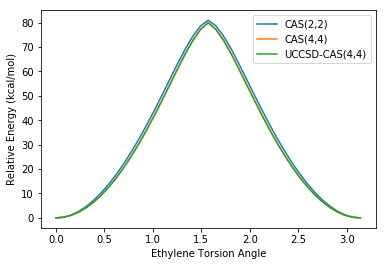

In [11]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Relative Energy (kcal/mol)")
for key in ['CAS(2,2)', 'CAS(4,4)']: #cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(cas_energies[key]) - cas_energies[key][0]),
              label=key)
for key in uccsd_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(uccsd_energies[key]) - uccsd_energies[key][0]),
               label="UCCSD-" + key)
pylab.legend()
pylab.savefig("Ethylene_UCCSD_8Qubit.pdf")

In [12]:
cmd_printer = _printer.CommandPrinter()
active_qubits = 8
active_electrons = 4
n_amplitudes = 2
packed_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
compiler_engine = MainEngine(cmd_printer)
wavefunction =[]
wavefunction = compiler_engine.allocate_qureg(active_qubits)
X | wavefunction[0]
X | wavefunction[1]
X | wavefunction[2]
X | wavefunction[3]
H | wavefunction[0]
H | wavefunction[1]
H | wavefunction[2]
Rx(-np.pi/2) | wavefunction[3]
CNOT | (wavefunction[0], wavefunction[1])
CNOT | (wavefunction[1], wavefunction[2])
CNOT | (wavefunction[2], wavefunction[3]) 
H | wavefunction[4]
H | wavefunction[5]
H | wavefunction[6]
Rx(-np.pi/2) | wavefunction[7]
CNOT | (wavefunction[4], wavefunction[5])
CNOT | (wavefunction[5], wavefunction[6])
CNOT | (wavefunction[6], wavefunction[7])            
Rz(packed_amplitudes[0]) | wavefunction[3]
Rz(packed_amplitudes[1]) | wavefunction[7]
CNOT | (wavefunction[2], wavefunction[3])            
CNOT | (wavefunction[1], wavefunction[2])
CNOT | (wavefunction[0], wavefunction[1])           
Rx(np.pi/2) | wavefunction[3]
H | wavefunction[2]
H | wavefunction[1]
H | wavefunction[0]
CNOT | (wavefunction[6], wavefunction[7]) 
CNOT | (wavefunction[5], wavefunction[6])
CNOT | (wavefunction[4], wavefunction[5])
Rx(np.pi/2) | wavefunction[7]
H | wavefunction[6]
H | wavefunction[5]
H | wavefunction[4]            
compiler_engine.flush()

Allocate | Qureg[0]
X | Qureg[0]
H | Qureg[0]
Allocate | Qureg[1]
X | Qureg[1]
H | Qureg[1]
CX | ( Qureg[0], Qureg[1] )
Allocate | Qureg[2]
X | Qureg[2]
H | Qureg[2]
CX | ( Qureg[1], Qureg[2] )
Allocate | Qureg[3]
X | Qureg[3]
Rx(10.995574287564276) | Qureg[3]
CX | ( Qureg[2], Qureg[3] )
Rz(0.0001525615233120949) | Qureg[3]
CX | ( Qureg[2], Qureg[3] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[0], Qureg[1] )
H | Qureg[0]
H | Qureg[1]
H | Qureg[2]
Rx(1.5707963267948966) | Qureg[3]
Allocate | Qureg[4]
H | Qureg[4]
Allocate | Qureg[5]
H | Qureg[5]
CX | ( Qureg[4], Qureg[5] )
Allocate | Qureg[6]
H | Qureg[6]
CX | ( Qureg[5], Qureg[6] )
Allocate | Qureg[7]
Rx(10.995574287564276) | Qureg[7]
CX | ( Qureg[6], Qureg[7] )
Rz(0.0007600985228309556) | Qureg[7]
CX | ( Qureg[6], Qureg[7] )
CX | ( Qureg[5], Qureg[6] )
CX | ( Qureg[4], Qureg[5] )
H | Qureg[4]
H | Qureg[5]
H | Qureg[6]
Rx(1.5707963267948966) | Qureg[7]


In [13]:
drawer = CircuitDrawer()
active_qubits = 8
active_electrons = 4
n_amplitudes = 2
packed_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
compiler_engine = MainEngine(drawer)
wavefunction =[]
wavefunction = compiler_engine.allocate_qureg(active_qubits)
X | wavefunction[0]
X | wavefunction[1]
X | wavefunction[2]
X | wavefunction[3]
H | wavefunction[0]
H | wavefunction[1]
H | wavefunction[2]
Rx(-np.pi/2) | wavefunction[3]
CNOT | (wavefunction[0], wavefunction[1])
CNOT | (wavefunction[1], wavefunction[2])
CNOT | (wavefunction[2], wavefunction[3]) 
H | wavefunction[4]
H | wavefunction[5]
H | wavefunction[6]
Rx(-np.pi/2) | wavefunction[7]
CNOT | (wavefunction[4], wavefunction[5])
CNOT | (wavefunction[5], wavefunction[6])
CNOT | (wavefunction[6], wavefunction[7])            
Rz(packed_amplitudes[0]) | wavefunction[3]
Rz(packed_amplitudes[1]) | wavefunction[7]
CNOT | (wavefunction[2], wavefunction[3])            
CNOT | (wavefunction[1], wavefunction[2])
CNOT | (wavefunction[0], wavefunction[1])           
Rx(np.pi/2) | wavefunction[3]
H | wavefunction[2]
H | wavefunction[1]
H | wavefunction[0]
CNOT | (wavefunction[6], wavefunction[7]) 
CNOT | (wavefunction[5], wavefunction[6])
CNOT | (wavefunction[4], wavefunction[5])
Rx(np.pi/2) | wavefunction[7]
H | wavefunction[6]
H | wavefunction[5]
H | wavefunction[4]            
compiler_engine.flush()
circuit = drawer.get_latex()
print()
print()
print(circuit)

Deallocate | Qureg[7]
Deallocate | Qureg[6]
Deallocate | Qureg[5]
Deallocate | Qureg[4]
Deallocate | Qureg[3]
Deallocate | Qureg[2]
Deallocate | Qureg[1]
Deallocate | Qureg[0]


\documentclass{standalone}
\usepackage[margin=1in]{geometry}
\usepackage[hang,small,bf]{caption}
\usepackage{tikz}
\usepackage{braket}
\usetikzlibrary{backgrounds,shadows.blur,fit,decorations.pathreplacing,shapes}

\begin{document}
\begin{tikzpicture}[scale=0.8, transform shape]

\tikzstyle{basicshadow}=[blur shadow={shadow blur steps=8, shadow xshift=0.7pt, shadow yshift=-0.7pt, shadow scale=1.02}]\tikzstyle{basic}=[draw,fill=white,basicshadow]
\tikzstyle{operator}=[basic,minimum size=1.5em]
\tikzstyle{phase}=[fill=black,shape=circle,minimum size=0.1cm,inner sep=0pt,outer sep=0pt,draw=black]
\tikzstyle{none}=[inner sep=0pt,outer sep=-.5pt,minimum height=0.5cm+1pt]
\tikzstyle{measure}=[operator,inner sep=0pt,minimum height=0.5cm, minimum width=0.75cm]
\tikzstyle{xstyle}=[circle,basic,minimum height=0.35cm,minim

In [14]:
cmd_printer = _printer.CommandPrinter()
active_qubits = 8
active_electrons = 4
n_amplitudes = int(uccsd_singlet_paramsize(active_qubits, active_electrons))
packed_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
compiler_engine = uccsd_trotter_engine(cmd_printer)
wavefunction = []
wavefunction = compiler_engine.allocate_qureg(active_qubits)
for i in range(active_electrons):
    X | wavefunction[i]
evolution_operator = uccsd_singlet_evolution(packed_amplitudes, active_qubits, active_electrons)
evolution_operator | wavefunction
compiler_engine.flush()

Allocate | Qureg[0]
Allocate | Qureg[1]
Allocate | Qureg[2]
Allocate | Qureg[3]
Allocate | Qureg[4]
Allocate | Qureg[5]
Allocate | Qureg[6]
Allocate | Qureg[7]
X | Qureg[0]
X | Qureg[1]
X | Qureg[2]
X | Qureg[3]
Rx(1.5707963267948966) | Qureg[0]
H | Qureg[4]
CX | ( Qureg[0], Qureg[1] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[2], Qureg[3] )
CX | ( Qureg[3], Qureg[4] )
Rz(12.564997293602726) | Qureg[4]
CX | ( Qureg[3], Qureg[4] )
CX | ( Qureg[2], Qureg[3] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[0], Qureg[1] )
H | Qureg[4]
Rx(10.995574287564276) | Qureg[0]
H | Qureg[0]
Rx(1.5707963267948966) | Qureg[4]
CX | ( Qureg[0], Qureg[1] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[2], Qureg[3] )
CX | ( Qureg[3], Qureg[4] )
Rz(0.0013733207564463668) | Qureg[4]
CX | ( Qureg[3], Qureg[4] )
CX | ( Qureg[2], Qureg[3] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[0], Qureg[1] )
Rx(10.995574287564276) | Qureg[4]
H | Qureg[0]
Rx(1.5707963267948966) | Qureg[1]
H | Qureg[5]
CX | ( Qureg[1], Qureg[2] )
CX | (

Rx(1.5707963267948966) | Qureg[3]
Rx(1.5707963267948966) | Qureg[4]
H | Qureg[5]
CX | ( Qureg[0], Qureg[1] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[2], Qureg[3] )
CX | ( Qureg[3], Qureg[4] )
CX | ( Qureg[4], Qureg[5] )
Rz(12.565831636887195) | Qureg[5]
CX | ( Qureg[4], Qureg[5] )
CX | ( Qureg[3], Qureg[4] )
CX | ( Qureg[2], Qureg[3] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[0], Qureg[1] )
H | Qureg[5]
Rx(10.995574287564276) | Qureg[4]
Rx(10.995574287564276) | Qureg[3]
Rx(10.995574287564276) | Qureg[0]
Rx(1.5707963267948966) | Qureg[0]
H | Qureg[3]
Rx(1.5707963267948966) | Qureg[4]
Rx(1.5707963267948966) | Qureg[5]
CX | ( Qureg[0], Qureg[1] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[2], Qureg[3] )
CX | ( Qureg[3], Qureg[4] )
CX | ( Qureg[4], Qureg[5] )
Rz(0.0005389774719781859) | Qureg[5]
CX | ( Qureg[4], Qureg[5] )
CX | ( Qureg[3], Qureg[4] )
CX | ( Qureg[2], Qureg[3] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[0], Qureg[1] )
Rx(10.995574287564276) | Qureg[5]
Rx(10.995574287564276) |

Rx(10.995574287564276) | Qureg[1]
H | Qureg[0]
Rx(1.5707963267948966) | Qureg[0]
H | Qureg[1]
H | Qureg[5]
H | Qureg[6]
CX | ( Qureg[0], Qureg[1] )
CX | ( Qureg[1], Qureg[5] )
CX | ( Qureg[5], Qureg[6] )
Rz(7.048521805554435e-05) | Qureg[6]
CX | ( Qureg[5], Qureg[6] )
CX | ( Qureg[1], Qureg[5] )
CX | ( Qureg[0], Qureg[1] )
H | Qureg[6]
H | Qureg[5]
H | Qureg[1]
Rx(10.995574287564276) | Qureg[0]
H | Qureg[0]
H | Qureg[1]
H | Qureg[5]
Rx(1.5707963267948966) | Qureg[6]
CX | ( Qureg[0], Qureg[1] )
CX | ( Qureg[1], Qureg[5] )
CX | ( Qureg[5], Qureg[6] )
Rz(12.566300129141117) | Qureg[6]
CX | ( Qureg[5], Qureg[6] )
CX | ( Qureg[1], Qureg[5] )
CX | ( Qureg[0], Qureg[1] )
Rx(10.995574287564276) | Qureg[6]
H | Qureg[5]
H | Qureg[1]
H | Qureg[0]
H | Qureg[0]
Rx(1.5707963267948966) | Qureg[1]
H | Qureg[5]
H | Qureg[6]
CX | ( Qureg[0], Qureg[1] )
CX | ( Qureg[1], Qureg[5] )
CX | ( Qureg[5], Qureg[6] )
Rz(7.048521805554435e-05) | Qureg[6]
CX | ( Qureg[5], Qureg[6] )
CX | ( Qureg[1], Qureg[5] )
CX |

CX | ( Qureg[4], Qureg[5] )
CX | ( Qureg[5], Qureg[6] )
CX | ( Qureg[6], Qureg[7] )
Rz(0.000271751368252276) | Qureg[7]
CX | ( Qureg[6], Qureg[7] )
CX | ( Qureg[5], Qureg[6] )
CX | ( Qureg[4], Qureg[5] )
CX | ( Qureg[2], Qureg[4] )
CX | ( Qureg[1], Qureg[2] )
H | Qureg[7]
H | Qureg[4]
Rx(10.995574287564276) | Qureg[2]
H | Qureg[1]
Rx(1.5707963267948966) | Qureg[1]
Rx(1.5707963267948966) | Qureg[2]
H | Qureg[4]
Rx(1.5707963267948966) | Qureg[7]
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[2], Qureg[4] )
CX | ( Qureg[4], Qureg[5] )
CX | ( Qureg[5], Qureg[6] )
CX | ( Qureg[6], Qureg[7] )
Rz(0.000271751368252276) | Qureg[7]
CX | ( Qureg[6], Qureg[7] )
CX | ( Qureg[5], Qureg[6] )
CX | ( Qureg[4], Qureg[5] )
CX | ( Qureg[2], Qureg[4] )
CX | ( Qureg[1], Qureg[2] )
Rx(10.995574287564276) | Qureg[7]
H | Qureg[4]
Rx(10.995574287564276) | Qureg[2]
Rx(10.995574287564276) | Qureg[1]
Rx(1.5707963267948966) | Qureg[2]
Rx(1.5707963267948966) | Qureg[3]
Rx(1.5707963267948966) | Qureg[4]
H | Qureg[7]
CX | (